In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)
    
    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")
    
    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")
            
            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )
            
            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")
            
        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")
    
    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")
    
    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")
    
    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + 
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)
    
    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])
    
    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])
    
    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    
    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")
    
    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")
    
    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")
    
    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")
    
    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")
    
    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }
    
    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)
    
    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)
    
    plt.suptitle(f'{split_name} Set - Prediction Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")
    
    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")
    
    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)
    
    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')
    
    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")
    
    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()
    
    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    
    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']
    
    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)
    
    df = df.copy()
    
    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    
    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))
    
    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 + 
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0
    
    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']
    
    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())
    
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())
    
    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
    
    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)
    
    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()
    
    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360
    
    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )
    
    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    print(f"\n📊 Features created: {len(df.columns)} total columns")
    
    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']
    
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)
    
    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]
    
    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]
    
    sequences = []
    static_data = []
    targets = []
    metadata = []
    
    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])
    
    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue
        
        group = group.sort_values('frame_id')
        
        if len(group) < sequence_length:
            continue
        
        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values
        
        sequences.append(seq_data)
        static_data.append(static)
        
        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])
        
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })
    
    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)
    
    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None
    
    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")
    
    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)
    
    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')
    
    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)
    
    combined = layers.concatenate([x, s])
    
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)
    
    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)
    
    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    model.summary()
    
    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)
    
    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }
    
    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])
        
        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65
        
        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })
    
    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")
    
    return submission_df

# ============================================================================
# MAIN PIPELINE WITH EVALUATION
# ============================================================================

'''def main():
    start_time = datetime.now()
    
    print("\n" + "="*80)
    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")
    print("="*80)
    
    # Setup GPU
    has_gpu = setup_gpu()
    
    # Load data
    train_df = load_training_data()
    test_input_df, test_targets_df = load_test_data()
    
    # Preprocess
    print("\n📍 Step 1: Normalizing play direction...")
    train_df = normalize_play_direction(train_df)
    test_input_df = normalize_play_direction(test_input_df)
    
    # Feature engineering
    print("\n📍 Step 2: Feature engineering...")
    train_df = engineer_features(train_df)
    test_input_df = engineer_features(test_input_df)
    
    # Encode categorical
    print("\n📍 Step 3: Encoding categorical variables...")
    train_df, encoders = encode_categorical(train_df)
    test_input_df = encode_categorical(test_input_df, encoders)
    
    # Create sequences
    print("\n📍 Step 4: Creating sequences...")
    X_seq_all, X_static_all, y_all, metadata_all = create_sequences(
        train_df, CONFIG['sequence_length'], for_training=True
    )
    
    X_seq_test, X_static_test, _, metadata_test = create_sequences(
        test_input_df, CONFIG['sequence_length'], for_training=False
    )
    
    # Split train/validation
    print("\n📍 Step 5: Splitting train/validation...")
    n_samples = len(X_seq_all)
    n_val = int(n_samples * CONFIG['validation_split'])
    
    # Random shuffle
    indices = np.random.permutation(n_samples)
    train_idx = indices[n_val:]
    val_idx = indices[:n_val]
    
    X_seq_train = X_seq_all[train_idx]
    X_static_train = X_static_all[train_idx]
    y_train = y_all[train_idx]
    
    X_seq_val = X_seq_all[val_idx]
    X_static_val = X_static_all[val_idx]
    y_val = y_all[val_idx]
    
    print(f"   Training samples: {len(X_seq_train):,}")
    print(f"   Validation samples: {len(X_seq_val):,}")
    
    # Scale features
    print("\n📍 Step 6: Scaling features...")
    scaler_seq = StandardScaler()
    scaler_static = StandardScaler()
    
    # Scale sequence features
    X_seq_train_flat = X_seq_train.reshape(-1, X_seq_train.shape[-1])
    X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train_flat).reshape(X_seq_train.shape)
    
    X_seq_val_flat = X_seq_val.reshape(-1, X_seq_val.shape[-1])
    X_seq_val_scaled = scaler_seq.transform(X_seq_val_flat).reshape(X_seq_val.shape)
    
    # Scale static features
    X_static_train_scaled = scaler_static.fit_transform(X_static_train)
    X_static_val_scaled = scaler_static.transform(X_static_val)
    
    # Scale test features
    X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
    X_seq_test_scaled = scaler_seq.transform(X_seq_test_flat).reshape(X_seq_test.shape)
    X_static_test_scaled = scaler_static.transform(X_static_test)
    
    # Build model
    print("\n📍 Step 7: Building model...")
    model = build_model(
        sequence_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
        static_shape=X_static_train.shape[1]
    )
    
    # Train model WITHOUT validation_split (we already split)
    print("\n📍 Step 8: Training model...")
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq_train_scaled, X_static_train_scaled], y_train,
        validation_data=([X_seq_val_scaled, X_static_val_scaled], y_val),
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    print("\n📍 Step 9: Plotting training history...")
    plot_training_history(history, "training_history.png")
    
    # Evaluate on training set
    print("\n📍 Step 10: Evaluating on training set...")
    y_train_pred = model.predict([X_seq_train_scaled, X_static_train_scaled], verbose=0)
    train_metrics = evaluate_predictions(y_train, y_train_pred, "Training")
    plot_predictions(y_train, y_train_pred, "Training", "predictions_train.png")
    
    # Evaluate on validation set
    print("\n📍 Step 11: Evaluating on validation set...")
    y_val_pred = model.predict([X_seq_val_scaled, X_static_val_scaled], verbose=0)
    val_metrics = evaluate_predictions(y_val, y_val_pred, "Validation")
    plot_predictions(y_val, y_val_pred, "Validation", "predictions_val.png")
    
    # Save model and artifacts
    print("\n📍 Step 12: Saving model and artifacts...")
    model.save('nfl_model_final.keras')
    with open('scalers.pkl', 'wb') as f:
        pickle.dump({'seq': scaler_seq, 'static': scaler_static, 'encoders': encoders}, f)
    
    # Save metrics to file
    metrics_summary = {
        'training': {
            'x_rmse': float(train_metrics['x_rmse']),
            'y_rmse': float(train_metrics['y_rmse']),
            'x_mae': float(train_metrics['x_mae']),
            'y_mae': float(train_metrics['y_mae']),
            'mean_distance': float(train_metrics['mean_distance']),
            'median_distance': float(train_metrics['median_distance'])
        },
        'validation': {
            'x_rmse': float(val_metrics['x_rmse']),
            'y_rmse': float(val_metrics['y_rmse']),
            'x_mae': float(val_metrics['x_mae']),
            'y_mae': float(val_metrics['y_mae']),
            'mean_distance': float(val_metrics['mean_distance']),
            'median_distance': float(val_metrics['median_distance'])
        }
    }
    
    with open('metrics.pkl', 'wb') as f:
        pickle.dump(metrics_summary, f)
    
    # Create submission
    print("\n📍 Step 13: Creating submission...")
    submission = create_submission(
        model, 
        (X_seq_test_scaled, X_static_test_scaled),
        test_targets_df,
        metadata_test,
        {'seq': scaler_seq, 'static': scaler_static}
    )
    
    # Final summary
    end_time = datetime.now()
    duration = end_time - start_time
    
    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETE!")
    print("="*80)
    
    print(f"\n⏱️  Total Time: {duration}")
    
    print(f"\n📁 Files created:")
    print(f"   • nfl_model_final.keras - Trained model")
    print(f"   • best_model.keras - Best model checkpoint")
    print(f"   • scalers.pkl - Feature scalers and encoders")
    print(f"   • metrics.pkl - Evaluation metrics")
    print(f"   • submission.csv - Final predictions ({len(submission):,} rows)")
    print(f"   • training_history.png - Training curves")
    print(f"   • predictions_train.png - Training set predictions")
    print(f"   • predictions_val.png - Validation set predictions")
    
    print(f"\n📊 FINAL RESULTS:")
    print(f"\n   Training Set:")
    print(f"      RMSE (X): {train_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {train_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {train_metrics['mean_distance']:.3f} yards")
    
    print(f"\n   Validation Set:")
    print(f"      RMSE (X): {val_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {val_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {val_metrics['mean_distance']:.3f} yards")
    
    print(f"\n🎯 Model Performance Summary:")
    within_5_val = (val_metrics['distances'] <= 5).sum() / len(val_metrics['distances']) * 100
    within_10_val = (val_metrics['distances'] <= 10).sum() / len(val_metrics['distances']) * 100
    print(f"   Predictions within 5 yards: {within_5_val:.1f}%")
    print(f"   Predictions within 10 yards: {within_10_val:.1f}%")
    
    print("\n" + "="*80)
    
    return model, history, submission, train_metrics, val_metrics'''

'''# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, submission, train_metrics, val_metrics = main()
    '''

'# ============================================================================\n# RUN\n# ============================================================================\n\nif __name__ == "__main__":\n    model, history, submission, train_metrics, val_metrics = main()\n    '

In [45]:
def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

In [46]:
train_df = load_training_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440


In [47]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [48]:
train_df.describe()

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

array([[<Axes: title={'center': 'game_id'}>,
        <Axes: title={'center': 'play_id'}>,
        <Axes: title={'center': 'nfl_id'}>,
        <Axes: title={'center': 'frame_id'}>],
       [<Axes: title={'center': 'absolute_yardline_number'}>,
        <Axes: title={'center': 'player_weight'}>,
        <Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 's'}>, <Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'dir'}>, <Axes: title={'center': 'o'}>],
       [<Axes: title={'center': 'num_frames_output'}>,
        <Axes: title={'center': 'ball_land_x'}>,
        <Axes: title={'center': 'ball_land_y'}>, <Axes: >]], dtype=object)

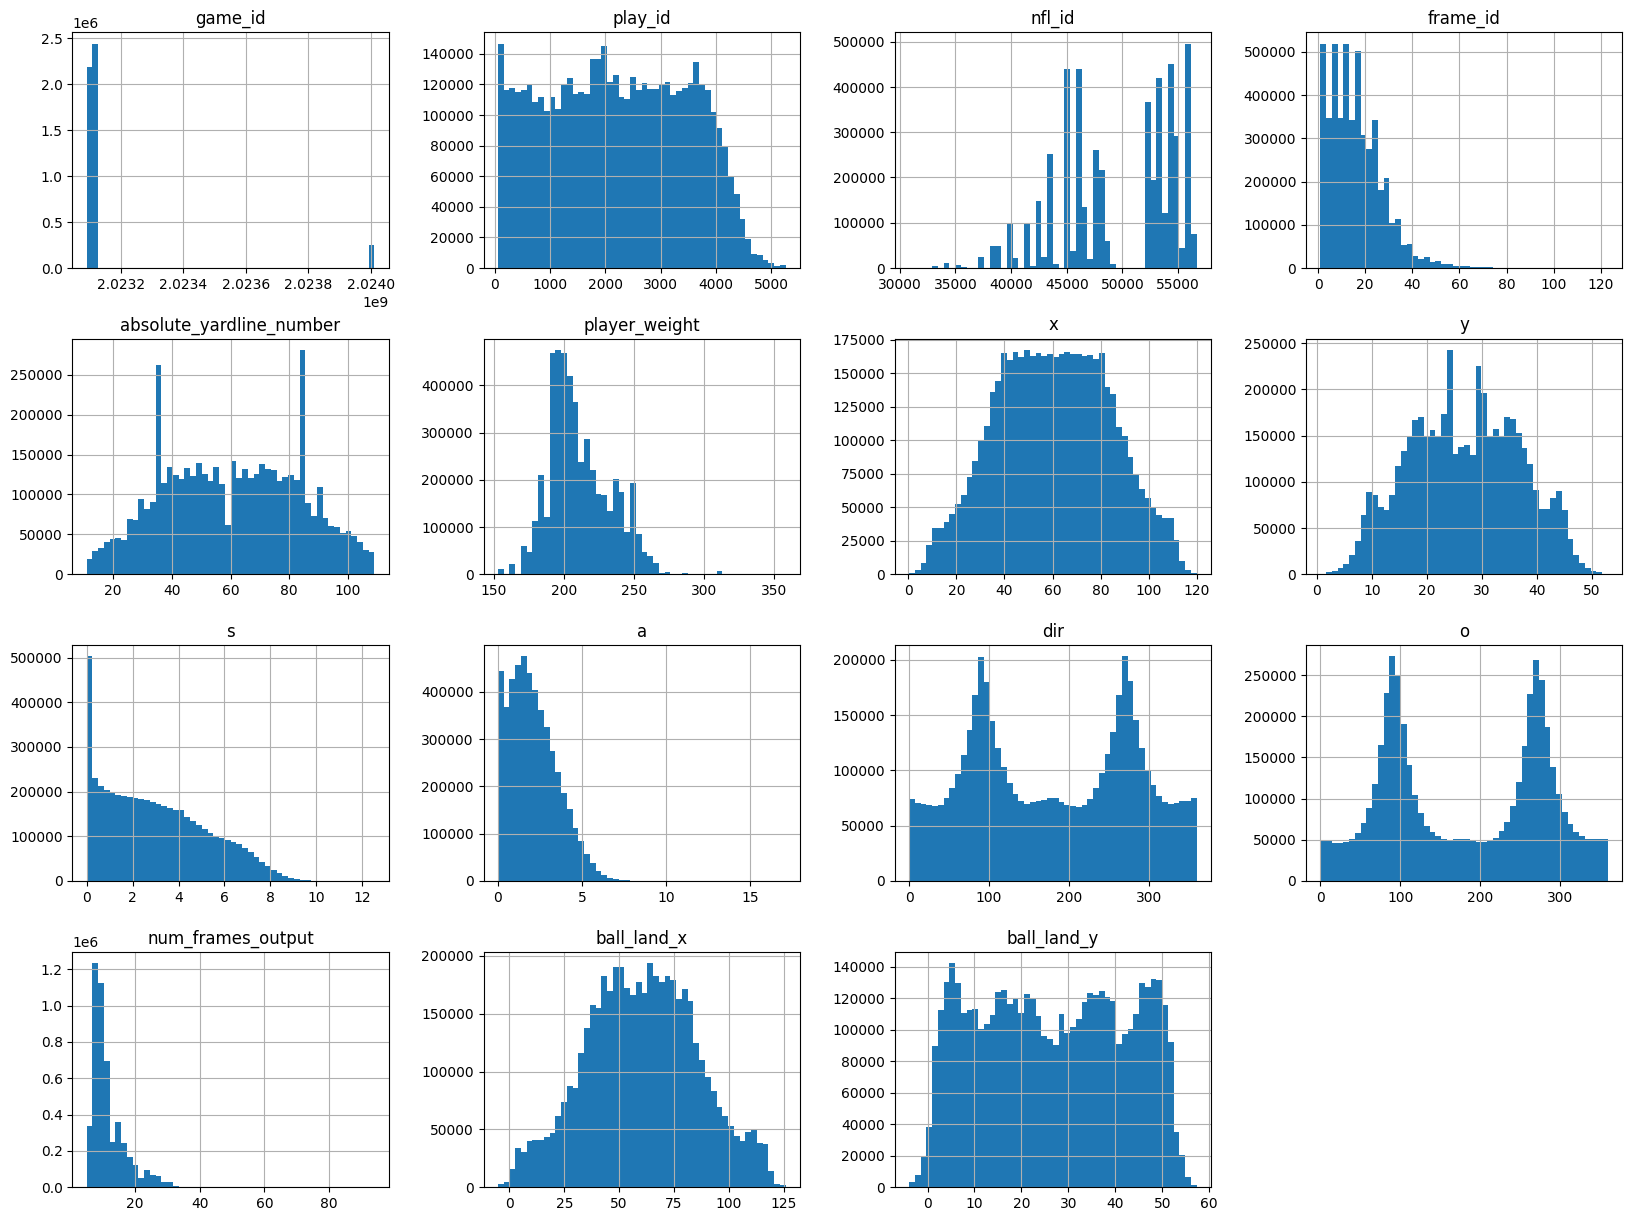

In [50]:
train_df.hist(bins=50, figsize=(20,15))

In [51]:
print(train_set.shape,test_set.shape)#se revisa el tamaño de los sets

NameError: name 'train_set' is not defined

In [ ]:
test_set.head()

In [ ]:
'''corr_matrix = train_df.corr() #función para calcular las correlaciones entre las variables
corr_matrix.style.background_gradient(cmap='')'''

## 3) Detecto numéricas y categóricas

Primero separo columnas **numéricas** de **categóricas**.  
Esto me permite aplicar el tratamiento correcto a cada tipo sin mezclar cosas.  
Reviso que `frame_id` quede como numérica (importa por el orden temporal) y que `play_direction`, `player_position`, `player_side`, `player_role` queden como categóricas.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303440 entries, 0 to 1303439
Data columns (total 46 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   nfl_id                          1303440 non-null  float64
 1   frame_id                        1303440 non-null  float64
 2   player_weight                   1303440 non-null  float64
 3   x                               1303440 non-null  float64
 4   y                               1303440 non-null  float64
 5   s                               1303440 non-null  float64
 6   a                               1303440 non-null  float64
 7   dir                             1303440 non-null  float64
 8   o                               1303440 non-null  float64
 9   num_frames_output               1303440 non-null  float64
 10  ball_land_x                     1303440 non-null  float64
 11  ball_land_y                     1303440 non-null  float64
 12  

,nfl_id,frame_id,player_weight,x,y,s,a,dir,o,num_frames_output,...,player_position_RB,player_position_S,player_position_SS,player_position_T,player_position_TE,player_position_WR,player_side_Defense,player_side_Offense,player_role_Defensive Coverage,player_role_Targeted Receiver
0,-3.695846,-1.371564,2.509397,1.179683,0.139699,-1.256512,-1.048621,0.427199,-1.261488,-0.469074,...,-0.224095,-0.061322,-0.32032,-0.00798,3.636112,-0.473738,-1.51127,1.51127,-1.51127,1.51127
1,-3.695846,-1.371564,2.509397,0.125605,0.317028,-1.357102,-0.957496,-0.081595,-1.611373,-0.993139,...,-0.224095,-0.061322,-0.32032,-0.00798,3.636112,-0.473738,-1.51127,1.51127,-1.51127,1.51127
2,-3.695846,-1.371564,2.509397,1.924115,-0.178708,-1.347958,-1.069649,0.665086,-1.131042,-0.643762,...,-0.224095,-0.061322,-0.32032,-0.00798,3.636112,-0.473738,-1.51127,1.51127,-1.51127,1.51127
3,-3.695846,-1.280862,2.509397,1.180537,0.134801,-1.187928,-0.719170,0.428163,-1.237877,-0.469074,...,-0.224095,-0.061322,-0.32032,-0.00798,3.636112,-0.473738,-1.51127,1.51127,-1.51127,1.51127
4,-3.695846,-1.280862,2.509397,0.126032,0.316048,-1.293090,-0.417758,-0.006999,-1.575797,-0.993139,...,-0.224095,-0.061322,-0.32032,-0.00798,3.636112,-0.473738,-1.51127,1.51127,-1.51127,1.51127


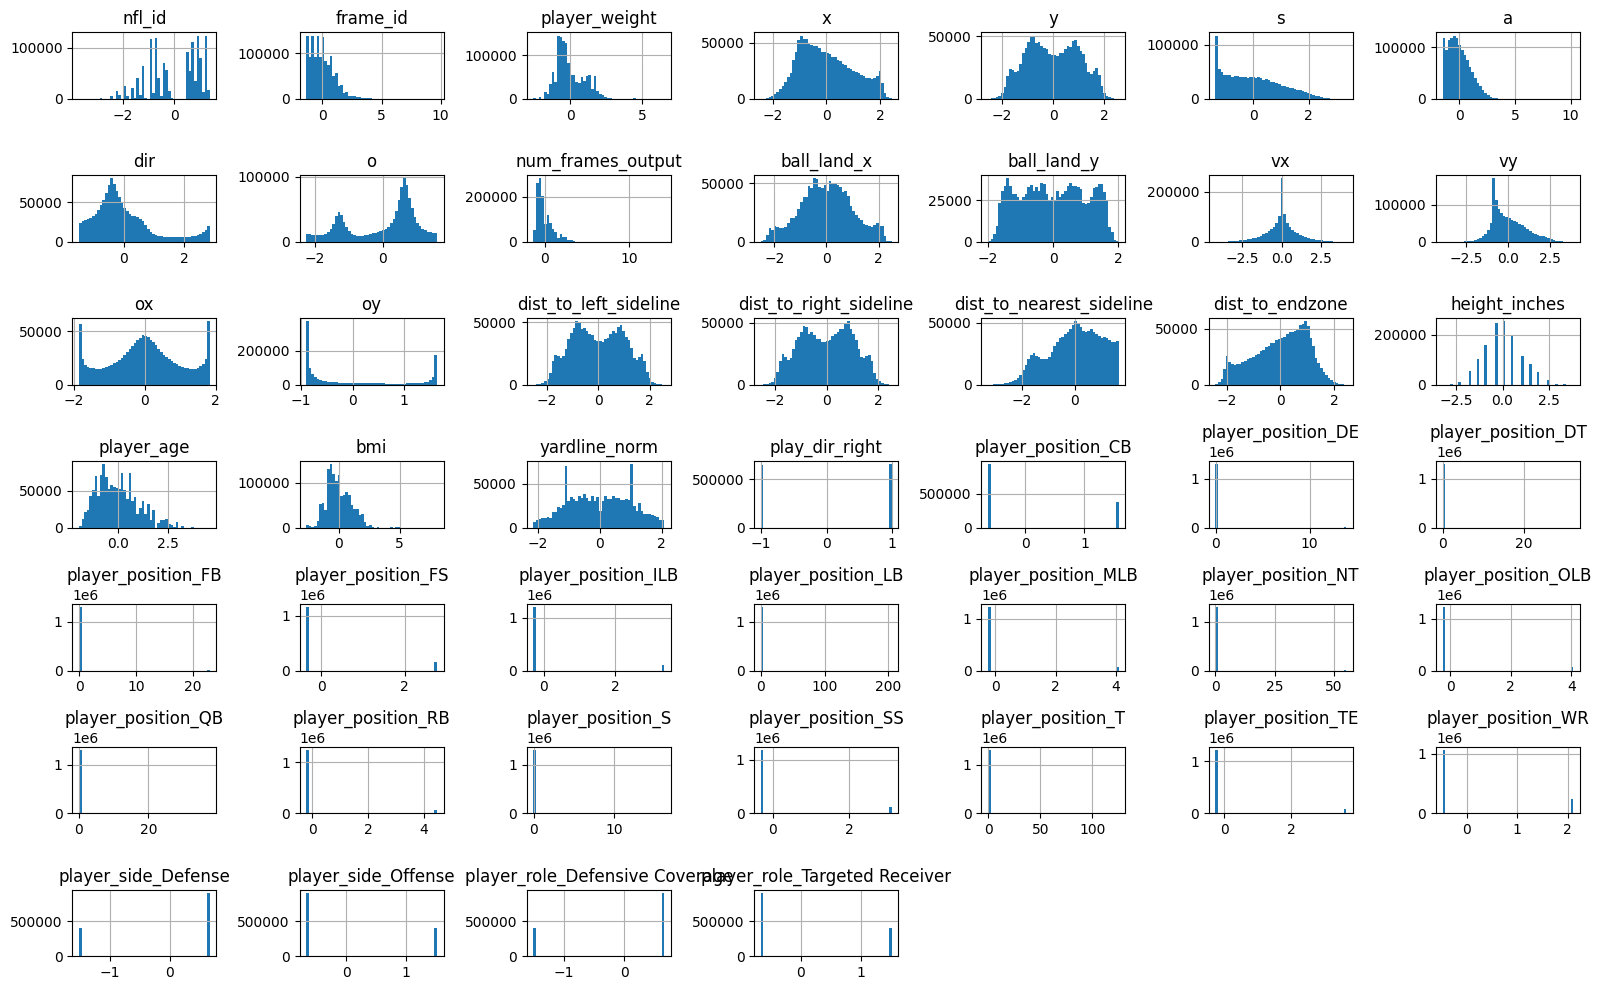

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math

# ==========================
# Constantes y utilidades
# ==========================
FIELD_LENGTH = 120.0   # yardas
FIELD_WIDTH  = 53.3    # yardas

def _parse_height_to_inches(s):
    """Convierte '6-1' -> 73. Si no es válido, retorna NaN."""
    if pd.isna(s):
        return np.nan
    try:
        parts = str(s).strip().split('-')
        ft = float(parts[0])
        inch = float(parts[1]) if len(parts) > 1 else 0.0
        return ft*12.0 + inch
    except Exception:
        return np.nan

def _safe_deg2rad(series):
    return np.deg2rad(pd.to_numeric(series, errors="coerce"))

def _reflect_play_direction(df):
    """
    Refleja coordenadas/ángulos cuando play_direction == 'left' para
    dejar todas las jugadas apuntando a la derecha.
    Cambios:
      x -> 120 - x
      y -> 53.3 - y
      dir -> (dir + 180) % 360
      o   -> (o + 180) % 360
    """
    df = df.copy()
    if "play_direction" not in df:
        return df

    mask_left = df["play_direction"].astype(str).str.lower().eq("left")

    for col, L in [("x", FIELD_LENGTH), ("y", FIELD_WIDTH)]:
        if col in df:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df.loc[mask_left, col] = L - df.loc[mask_left, col]

    for ang_col in ["dir", "o"]:
        if ang_col in df:
            col = pd.to_numeric(df[ang_col], errors="coerce")
            col.loc[mask_left] = (col.loc[mask_left] + 180.0) % 360.0
            df[ang_col] = col

    return df

def _engineer_kinematics(df):
    df = df.copy()
    for col in ["s", "a", "x", "y", "dir", "o"]:
        if col in df:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Componentes de velocidad
    if {"s", "dir"}.issubset(df.columns):
        dir_rad = _safe_deg2rad(df["dir"])
        df["vx"] = df["s"] * np.cos(dir_rad)
        df["vy"] = df["s"] * np.sin(dir_rad)
    else:
        df["vx"] = np.nan
        df["vy"] = np.nan

    # Orientación unitaria
    if "o" in df:
        o_rad = _safe_deg2rad(df["o"])
        df["ox"] = np.cos(o_rad)
        df["oy"] = np.sin(o_rad)
    else:
        df["ox"] = np.nan
        df["oy"] = np.nan

    # Distancias
    if "y" in df:
        df["dist_to_left_sideline"]  = df["y"]
        df["dist_to_right_sideline"] = FIELD_WIDTH - df["y"]
        df["dist_to_nearest_sideline"] = df[["dist_to_left_sideline","dist_to_right_sideline"]].min(axis=1)
    else:
        df["dist_to_left_sideline"] = df["dist_to_right_sideline"] = df["dist_to_nearest_sideline"] = np.nan

    if "x" in df:
        df["dist_to_endzone"] = FIELD_LENGTH - df["x"]
    else:
        df["dist_to_endzone"] = np.nan

    return df

def _player_attributes(df):
    df = df.copy()

    # 1) Altura: usar 'player_height_in' si ya viene numérica; si no, convertir 'player_height'
    height_col = None
    if "player_height_in" in df:
        df["height_inches"] = pd.to_numeric(df["player_height_in"], errors="coerce")
        height_col = "height_inches"
    elif "player_height" in df:
        df["height_inches"] = df["player_height"].apply(_parse_height_to_inches)
        height_col = "height_inches"
    else:
        df["height_inches"] = np.nan

    if height_col:
        if df["height_inches"].isna().all():
            # si todas son NaN, no podemos imputar con mediana -> dejar NaN
            pass
        else:
            df["height_inches"] = df["height_inches"].fillna(df["height_inches"].median())

    # 2) Peso
    if "player_weight" in df:
        df["player_weight"] = pd.to_numeric(df["player_weight"], errors="coerce")
        if not df["player_weight"].isna().all():
            df["player_weight"] = df["player_weight"].fillna(df["player_weight"].median())
    else:
        df["player_weight"] = np.nan

    # 3) Edad
    if "player_birth_date" in df:
        ref = pd.Timestamp("2023-09-01")
        bd = pd.to_datetime(df["player_birth_date"], errors="coerce")
        age_days = (ref - bd).dt.days
        df["player_age"] = (age_days / 365.25).astype(float)
        if not df["player_age"].isna().all():
            df["player_age"] = df["player_age"].fillna(df["player_age"].median())
    else:
        # si no existe la columna, créala como NaN
        if "player_age" not in df:
            df["player_age"] = np.nan

    # 4) BMI
    with np.errstate(divide='ignore', invalid='ignore'):
        df["bmi"] = 703.0 * df["player_weight"] / (df["height_inches"]**2)
    df["bmi"] = df["bmi"].replace([np.inf, -np.inf], np.nan)
    if not df["bmi"].isna().all():
        df["bmi"] = df["bmi"].fillna(df["bmi"].median())

    return df

def _normalize_yardline(df):
    df = df.copy()
    if "absolute_yardline_number" in df:
        df["absolute_yardline_number"] = pd.to_numeric(df["absolute_yardline_number"], errors="coerce")
        df["yardline_norm"] = df["absolute_yardline_number"] / FIELD_LENGTH
    else:
        df["yardline_norm"] = np.nan
    return df

def _encode_categoricals(df):
    df = df.copy()
    if "play_direction" in df:
        df["play_dir_right"] = (df["play_direction"].astype(str).str.lower() == "right").astype(int)

    cat_cols = []
    if "player_position" in df: cat_cols.append("player_position")
    if "player_side" in df:     cat_cols.append("player_side")
    if "player_role" in df:     cat_cols.append("player_role")

    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, dummy_na=False)

    return df

def transform_tracking_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pipeline de transformación completo:
    - Filtra player_to_predict == True (si existe)
    - Refleja jugadas 'left' -> 'right'
    - Ingeniería de características cinemáticas y de campo
    - Atributos del jugador (altura/edad/BMI con soporte a player_height_in)
    - Normaliza yardline
    - One-hot de categóricas
    - Quita columnas no útiles o con leakage
    - Convierte booleanos a enteros (para poder escalar y correlacionar)
    """
    df = df.copy()

    # 1) Filtrar filas de interés
    if "player_to_predict" in df.columns:
        df = df[df["player_to_predict"] == True].copy()

    # 2) Reflejar según dirección
    df = _reflect_play_direction(df)

    # 3) Ingeniería de características
    df = _engineer_kinematics(df)

    # 4) Atributos del jugador
    df = _player_attributes(df)

    # 5) Yardline normalizado
    df = _normalize_yardline(df)

    # 6) Categóricas -> dummies
    df = _encode_categoricals(df)

    # 7) Remover columnas no útiles / leakage
    drop_cols = [
        # identificadores sin valor predictivo
        "game_id", "play_id", "player_name",
        # usada solo para filtrar
        "player_to_predict",
        # fecha original
        "player_birth_date",
        # yardline original
        "absolute_yardline_number",
        # categóricas ya codificadas
        "player_position", "player_side", "player_role",
        # dirección textual (ya reflejada y / o codificada)
        "play_direction",
        # si existe la original de altura en pulgadas, ya la copiamos a 'height_inches'
        "player_height_in","player_height"
    ]
    drop_cols = [c for c in drop_cols if c in df.columns]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    # 8) Mantener ids útiles al frente
    keep_first = ["nfl_id", "frame_id"]
    order_cols = [c for c in keep_first if c in df.columns] + [c for c in df.columns if c not in keep_first]
    df = df[order_cols]

    # 9) Convertir bool -> int (para poder escalar y correlacionar)
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
    for c in bool_cols:
        df[c] = df[c].astype(int)

    # 10) Orden estable por ids si existen
    sort_cols = [c for c in ["nfl_id", "frame_id"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols, kind="stable").reset_index(drop=True)

    return df

def scale_numeric(df: pd.DataFrame):
    """
    Escala todas las columnas numéricas (incluye int, float, y las dummies ya pasadas a int).
    Devuelve df_scaled y el scaler.
    *Si NO quieres escalar las etiquetas x,y, coméntalas en 'num_cols'.
    """
    df_scaled = df.copy()

    # Convertir todo posible a numérico (por robustez)
    for c in df_scaled.columns:
        if df_scaled[c].dtype == "object":
            df_scaled[c] = pd.to_numeric(df_scaled[c], errors="ignore")

    # Columnas numéricas (int/float)
    num_cols = df_scaled.select_dtypes(include=["float64", "float32", "int64", "int32"]).columns.tolist()

    # Si quieres mantener y (targets) sin escalar, descomenta:
    # for t in ["x", "y"]:
    #     if t in num_cols:
    #         num_cols.remove(t)

    scaler = StandardScaler()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

    return df_scaled, scaler

def plot_histograms_per_column(df: pd.DataFrame, bins=50, figsize=(6,4)):
    """
    Genera un histograma por columna numérica.
    Crea una figura por columna (pueden ser muchas).
    """
    numeric_cols = df.select_dtypes(include=["float64", "float32", "int64", "int32"]).columns
    for col in numeric_cols:
        plt.figure(figsize=figsize)
        df[col].hist(bins=bins)
        plt.title(f"Histograma: {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()


# ==========================
# APLICACIÓN
# ==========================
train_df_transformed = transform_tracking_dataframe(train_df)

# Escalado (normalización estándar) de todas las columnas numéricas
df_scaled, scaler = scale_numeric(train_df_transformed)

# Eliminar filas que no tienen valores de salida (targets)
train_df_transformed = train_df_transformed.dropna(subset=["x", "y"])

# Ver la estructura final escalada
df_scaled.info()

# (Opcional) ver algunas filas para “ojo clínico”
display(df_scaled.head())

# Histogramas por columna (post-escalado)
df_scaled.hist(bins=50, figsize=(16,10))
plt.tight_layout()
plt.show()

In [54]:
# Obtener los nombres de las columnas del DataFrame escalado
features = df_scaled.columns.tolist()

# Imprimir la lista de features
print("Features generadas:")
print(features)

Features generadas:
['nfl_id', 'frame_id', 'player_weight', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'vx', 'vy', 'ox', 'oy', 'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline', 'dist_to_endzone', 'height_inches', 'player_age', 'bmi', 'yardline_norm', 'play_dir_right', 'player_position_CB', 'player_position_DE', 'player_position_DT', 'player_position_FB', 'player_position_FS', 'player_position_ILB', 'player_position_LB', 'player_position_MLB', 'player_position_NT', 'player_position_OLB', 'player_position_QB', 'player_position_RB', 'player_position_S', 'player_position_SS', 'player_position_T', 'player_position_TE', 'player_position_WR', 'player_side_Defense', 'player_side_Offense', 'player_role_Defensive Coverage', 'player_role_Targeted Receiver']


In [55]:
import re, pandas as pd

# ¿Hay cuDF?
try:
    import cudf
    HAS_CUDF = True
except Exception:
    HAS_CUDF = False

def is_df(obj):
    if isinstance(obj, pd.DataFrame): return "pandas"
    if HAS_CUDF and isinstance(obj, cudf.DataFrame): return "cudf"
    return None

def cols_str(obj):
    try:
        return [str(c) for c in obj.columns]
    except Exception:
        return []

# Tomamos snapshot para evitar "dictionary changed size during iteration"
G = dict(globals())

cands = []  # (name, kind, obj, shape, score, hints)
for name, obj in list(G.items()):
    kind = is_df(obj)
    if not kind:
        continue
    cols = set(map(str, cols_str(obj)))
    if not cols:
        continue

    # patrones tolerantes a nombres (gameId|game_id|gameid, etc.)
    has_game = any(re.fullmatch(r'(?i)game[_]*id', c) for c in cols) or any('game' in c.lower() and 'id' in c.lower() for c in cols)
    has_play = any(re.fullmatch(r'(?i)play[_]*id', c) for c in cols) or any('play' in c.lower() and 'id' in c.lower() for c in cols)

    # targets típicos del track 2026 (permitimos variantes)
    has_blx = any(re.search(r'(?i)ball.*land.*x', c) for c in cols)
    has_bly = any(re.search(r'(?i)ball.*land.*y', c) for c in cols)

    # Puntuación para elegir candidato:
    score = 0
    if has_game: score += 2
    if has_play: score += 2
    if has_blx and has_bly: score += 3
    elif has_blx or has_bly: score += 1

    shp = getattr(obj, "shape", (0,0))
    hints = {
        "has_gameId_like": has_game,
        "has_playId_like": has_play,
        "has_ball_land_x": has_blx,
        "has_ball_land_y": has_bly,
        "ncols": len(cols)
    }
    if score > 0:
        cands.append((name, kind, obj, shp, score, hints))

print("— Candidatos —")
for name, kind, obj, shp, score, hints in sorted(cands, key=lambda t:(t[4], t[3][0]), reverse=True):
    print(f"{name:25s} | {kind:6s} | shape={shp} | score={score} | {hints}")

if not cands:
    raise RuntimeError(
        "No hay DataFrames en memoria con columnas parecidas a gameId/playId. "
        "👉 Vuelve a ejecutar las celdas de CARGA/LIMPIEZA (donde se hace read_csv o merges) y corre de nuevo este bloque."
    )

# elegimos el mejor por score y tamaño
name_sel, kind_sel, obj_sel, shp_sel, score_sel, hints_sel = sorted(
    cands, key=lambda t:(t[4], t[3][0]), reverse=True
)[0]

# Asignamos df
if kind_sel == "cudf":
    df = obj_sel.copy(deep=True)
else:
    df = obj_sel.copy()

print(f"\n✅ Usando df = {name_sel} | tipo={kind_sel} | shape={shp_sel} | score={score_sel} | hints={hints_sel}")

# Mostramos algunas columnas para confirmar
print("\nAlgunas columnas:", list(map(str, df.columns))[:25])



— Candidatos —
train_df                  | pandas | shape=(4880579, 23) | score=7 | {'has_gameId_like': True, 'has_playId_like': True, 'has_ball_land_x': True, 'has_ball_land_y': True, 'ncols': 23}
obj_sel                   | pandas | shape=(4880579, 23) | score=7 | {'has_gameId_like': True, 'has_playId_like': True, 'has_ball_land_x': True, 'has_ball_land_y': True, 'ncols': 23}
df                        | pandas | shape=(4880579, 23) | score=7 | {'has_gameId_like': True, 'has_playId_like': True, 'has_ball_land_x': True, 'has_ball_land_y': True, 'ncols': 23}
df_train                  | pandas | shape=(2919876, 23) | score=7 | {'has_gameId_like': True, 'has_playId_like': True, 'has_ball_land_x': True, 'has_ball_land_y': True, 'ncols': 23}
df_temp                   | pandas | shape=(1960703, 23) | score=7 | {'has_gameId_like': True, 'has_playId_like': True, 'has_ball_land_x': True, 'has_ball_land_y': True, 'ncols': 23}
test_set                  | pandas | shape=(984681, 23) | score=7 | {'

# 1) Dataset elegido y columnas clave

Usamos `train_df` como base porque contiene los frames de seguimiento y las etiquetas que necesitamos. Renombramos `game_id→gameId` y `play_id→playId` para unificarlas.  
**Targets:** `ball_land_x`, `ball_land_y` (punto de aterrizaje del balón).  
**Features:** tomamos variables de tracking y contexto (posición, velocidad, aceleración, dirección/orientación, `absolute_yardline_number`, `frame_id`, y categóricas como `play_direction`, `player_position`, `player_side`, `player_role`).  
**Excluimos** identificadores y textos (`gameId`, `playId`, `nfl_id`, `player_name`, `player_birth_date`, `player_to_predict`) para evitar fuga de información o alta cardinalidad inútil.

> Objetivo: dejar un conjunto de columnas limpio, reproducible y sin “trampas” antes de partir el dataset.


In [56]:
# === 1) Normalizar nombres de columnas y definir targets ===
df = train_df.copy()   # (ya te salió "Usando df = train_df")

rename_map = {}
if 'game_id' in df.columns and 'gameId' not in df.columns:
    rename_map['game_id'] = 'gameId'
if 'play_id' in df.columns and 'playId' not in df.columns:
    rename_map['play_id'] = 'playId'

df = df.rename(columns=rename_map)

# Targets del track
target_cols = ['ball_land_x', 'ball_land_y']

# Verificación mínima
req = {'gameId','playId','ball_land_x','ball_land_y'}
missing = req - set(map(str, df.columns))
assert not missing, f"Faltan columnas requeridas: {missing}"
print("OK: df con gameId/playId y ball_land_x/y")


OK: df con gameId/playId y ball_land_x/y


In [58]:
# === 2) Features sin fuga/IDs/altas cardinalidades ===

# IDs o llaves que no deben ir como features (pero CONSERVAMOS frame_id):
ID_COLS = {'gameId','playId','nfl_id'}  # 'frame_id' se queda

# Alta cardinalidad (evitar OHE gigante y potencial fuga indirecta)
HIGH_CARD_COLS = {'player_name', 'player_birth_date'}

# Columna riesgosa que filtra el objetivo (evitar fuga del receptor objetivo)
LEAKY_IDENTITY = {'player_to_predict'}

# Targets no pueden estar en features
FORBIDDEN = set(target_cols) | ID_COLS | HIGH_CARD_COLS | LEAKY_IDENTITY

feature_cols = [c for c in df.columns if c not in FORBIDDEN]

# Chequeo anti-fuga
leaks = set(feature_cols) & set(target_cols)
assert not leaks, f"Fuga: {leaks} aparecen en features y targets."
print(f"Nº de features: {len(feature_cols)}")
print("Ejemplo de features:", feature_cols[:20])


Nº de features: 15
Ejemplo de features: ['frame_id', 'play_direction', 'absolute_yardline_number', 'player_height', 'player_weight', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output']


# 2) Split 60/20/20 por jugada (sin fuga)

Separamos en **train 60%**, **validación 20%** y **test 20%** **agrupando por jugada** (`gameId`–`playId`) con `GroupShuffleSplit`.  
Así evitamos que frames de **la misma jugada** caigan en splits distintos (eso sería fuga de información).  
Al final comprobamos que no haya solapamiento entre splits y armamos `X_train/X_val/X_test` con **las mismas columnas**.

Checklist rápido:
- ✅ “Split shapes” imprime tamaños coherentes.
- ✅ `assert` de solapamiento pasa sin errores.
- ✅ `X_*` tiene mismo nº de columnas y `y_*` es 2D con (`ball_land_x`,`ball_land_y`).


In [59]:
# === 3) Split por jugada: 60/20/20 (limpio, sin '...') ===
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
import numpy as np

# Asegúrate de haber ejecutado antes la celda donde hiciste:
# df = train_df.copy()
# df = df.rename(columns={'game_id':'gameId', 'play_id':'playId'})
# target_cols = ['ball_land_x','ball_land_y']
# y la celda donde defines feature_cols (sin IDs ni targets)

# 1) Grupo por jugada
groups = df['gameId'].astype(str) + '_' + df['playId'].astype(str)

# 2) 60% train / 40% temp
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.40, random_state=42)
train_idx, temp_idx = next(gss1.split(df, groups=groups))

df_train = df.iloc[train_idx].copy()
df_temp  = df.iloc[temp_idx].copy()

# 3) temp -> 50% val / 50% test  (20%/20% del total)
groups_temp = df_temp['gameId'].astype(str) + '_' + df_temp['playId'].astype(str)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(df_temp, groups=groups_temp))

val_set  = df_temp.iloc[val_idx].copy()
test_set = df_temp.iloc[test_idx].copy()

print("Split shapes ->",
      "train:", df_train.shape,
      "val:",   val_set.shape,
      "test:",  test_set.shape)

# 4) Construir X/y con las columnas ya definidas en 'feature_cols' y 'target_cols'
X_train = df_train[feature_cols].copy(); y_train = df_train[target_cols].copy()
X_val   = val_set[feature_cols].copy();  y_val   = val_set[target_cols].copy()
X_test  = test_set[feature_cols].copy(); y_test  = test_set[target_cols].copy()

print("X shapes ->", X_train.shape, X_val.shape, X_test.shape)
print("y shapes ->", y_train.shape, y_val.shape, y_test.shape)

# 5) Verificación: ninguna jugada debe repetirse entre splits
def plays(df_):
    return set((df_['gameId'].astype(str) + '_' + df_['playId'].astype(str)).unique())

assert not (plays(df_train) & plays(val_set)),  "Solapamiento train/val"
assert not (plays(df_train) & plays(test_set)), "Solapamiento train/test"
assert not (plays(val_set)  & plays(test_set)), "Solapamiento val/test"
print("OK: Split por jugada sin solapamientos.")


Split shapes -> train: (2919876, 23) val: (976022, 23) test: (984681, 23)
X shapes -> (2919876, 15) (976022, 15) (984681, 15)
y shapes -> (2919876, 2) (976022, 2) (984681, 2)
OK: Split por jugada sin solapamientos.


In [60]:
import numpy as np
import pandas as pd

# 1) Detectar columnas numéricas y categóricas basadas en X_train
num_cols = [c for c in X_train.columns if np.issubdtype(pd.Series(X_train[c]).dtype, np.number)]
cat_cols = [c for c in X_train.columns if c not in num_cols]

print(f"num_cols  ({len(num_cols)}): {num_cols}")
print(f"cat_cols  ({len(cat_cols)}): {cat_cols}")

# TIP: si ves columnas que deberían ser categóricas (p.ej. 'play_direction','player_side','player_role','player_position')
# y no aparecen en cat_cols, es porque ya son numéricas; si quieres forzarlas a categóricas, puedes hacer:
# X_train['play_direction'] = X_train['play_direction'].astype('category')
# ... y repetir la detección.


num_cols  (10): ['frame_id', 'absolute_yardline_number', 'player_weight', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output']
cat_cols  (5): ['play_direction', 'player_height', 'player_position', 'player_side', 'player_role']


## 4) Imputo faltantes y fijo el vocabulario (one-hot) sin fuga

Relleno faltantes: **mediana** para numéricas y **modo** para categóricas, aprendiendo **solo con train**.  
Luego hago **one-hot** en train y **reindexo** validación/test para que usen **exactamente** las mismas columnas.  
Así evito fuga de información y me quedo con matrices alineadas en los tres splits.


In [61]:
from sklearn.impute import SimpleImputer

# Imputadores
imp_num = SimpleImputer(strategy='median')
imp_cat = SimpleImputer(strategy='most_frequent')

# === Numéricas ===
Xtr_num = pd.DataFrame(imp_num.fit_transform(pd.DataFrame(X_train[num_cols])),
                       columns=num_cols, index=X_train.index)
Xva_num = pd.DataFrame(imp_num.transform(pd.DataFrame(X_val[num_cols])),
                       columns=num_cols, index=X_val.index)
Xte_num = pd.DataFrame(imp_num.transform(pd.DataFrame(X_test[num_cols])),
                       columns=num_cols, index=X_test.index)

# === Categóricas ===
if cat_cols:
    # Forzar a categoría para ahorrar memoria y estandarizar
    Xtr_cat_src = pd.DataFrame({c: X_train[c].astype('category') for c in cat_cols}, index=X_train.index)
    Xva_cat_src = pd.DataFrame({c: X_val[c].astype('category')   for c in cat_cols}, index=X_val.index)
    Xte_cat_src = pd.DataFrame({c: X_test[c].astype('category')  for c in cat_cols}, index=X_test.index)

    Xtr_cat = pd.DataFrame(imp_cat.fit_transform(Xtr_cat_src), columns=cat_cols, index=X_train.index)
    Xva_cat = pd.DataFrame(imp_cat.transform(Xva_cat_src),     columns=cat_cols, index=X_val.index)
    Xte_cat = pd.DataFrame(imp_cat.transform(Xte_cat_src),     columns=cat_cols, index=X_test.index)
else:
    Xtr_cat = Xva_cat = Xte_cat = pd.DataFrame(index=X_train.index)


In [62]:
# One-Hot solo si hay categóricas
if cat_cols:
    # Entrenamos "el vocabulario" con TRAIN
    Xtr_cat_oh = pd.get_dummies(Xtr_cat.astype('category'), dummy_na=True)
    oh_cols = Xtr_cat_oh.columns  # << ESTA es la lista maestra de columnas one-hot

    # Aplicamos a VAL/TEST reindexando a las columnas de TRAIN
    Xva_cat_oh = pd.get_dummies(Xva_cat.astype('category'), dummy_na=True)\
                    .reindex(columns=oh_cols, fill_value=0)
    Xte_cat_oh = pd.get_dummies(Xte_cat.astype('category'), dummy_na=True)\
                    .reindex(columns=oh_cols, fill_value=0)
else:
    Xtr_cat_oh = Xva_cat_oh = Xte_cat_oh = pd.DataFrame(index=X_train.index)
    oh_cols = []


## 5) Uno todo, escalo solo numéricas y verifico

Combino numéricas + dummies en `X_*_full`, **ordeno** columnas y **escaleo solo** las numéricas (fit en train, transform en val/test).  
Hago chequeos: mismas columnas en los tres splits y sin NaN/Inf.  
Quedo listo para entrenar modelos sin sorpresas de formato.


In [63]:
# Concatenar
X_train_full = pd.concat([Xtr_num, Xtr_cat_oh], axis=1)
X_val_full   = pd.concat([Xva_num, Xva_cat_oh], axis=1)
X_test_full  = pd.concat([Xte_num, Xte_cat_oh], axis=1)

# Ordena columnas por nombre para garantizar el orden idéntico
X_train_full = X_train_full.reindex(sorted(X_train_full.columns), axis=1)
X_val_full   = X_val_full.reindex(columns=X_train_full.columns, fill_value=0)
X_test_full  = X_test_full.reindex(columns=X_train_full.columns, fill_value=0)

# Opcional: castea a float32 para ahorrar memoria (muy útil con millones de filas)
X_train_full = X_train_full.astype(np.float32)
X_val_full   = X_val_full.astype(np.float32)
X_test_full  = X_test_full.astype(np.float32)

print("Shapes post-concat:", X_train_full.shape, X_val_full.shape, X_test_full.shape)


Shapes post-concat: (2919876, 55) (976022, 55) (984681, 55)


## 10bis) Presupuesto de 1,000,000 “parámetros”

Para que los modelos no se “vayan de tamaño”, fijé un **tope global** de ~**1 millón**.  
En árboles/boosting lo interpreto como **hojas totales** (≈ parámetros), y en kernels limito cuántas filas uso para entrenar.  
Así mantengo tiempos razonables y comparaciones justas entre métodos.


In [64]:
# === Presupuesto global de parámetros ===
BUDGET_PARAMS = 1_000_000  # 1 millón

# === Helpers de coste aproximado por tipo de modelo ===
import math

def approx_params_linear(n_features, n_outputs=2, with_intercept=True):
    """
    Linear/Lasso/ElasticNet/SGD/BayesianRidge:
    #params ≈ (n_features + intercept) * n_outputs
    """
    base = n_features + (1 if with_intercept else 0)
    return base * n_outputs

def approx_params_full_binary_tree(max_depth):
    """
    Para árboles 'llenos': #hojas ≈ 2^max_depth; #nodos ≈ 2^(max_depth+1)-1
    Usaremos hojas como proxy de parámetros (cada hoja tiene un valor).
    """
    leaves = 2 ** max_depth
    nodes  = (2 ** (max_depth + 1)) - 1
    return leaves, nodes

def approx_params_forest(n_estimators, max_depth):
    """
    RandomForest (y árvores base de GBDT) aprox: total_leaf_params ≈ sum(leaves_por_árbol).
    """
    leaves, _ = approx_params_full_binary_tree(max_depth)
    return int(n_estimators * leaves)

def approx_params_boosted(n_estimators, max_depth=None, max_leaves=None, grow_policy="depthwise"):
    """
    Boosting (XGBoost/GBR). Si grow_policy='lossguide' y max_leaves está definido,
    usamos max_leaves. Si no, usamos 2^max_depth.
    """
    if grow_policy == "lossguide" and max_leaves is not None:
        leaves = int(max_leaves)
    else:
        if max_depth is None:
            raise ValueError("Para 'depthwise' necesitas max_depth.")
        leaves = 2 ** max_depth
    return int(n_estimators * leaves)

def approx_params_svr_upper_bound(n_train_used, n_outputs=2):
    """
    SVR (kernel RBF) peor caso: #SV ≈ #entrenamiento. Como entrenamos dos salidas,
    cota ≈ 2 * n_train_used. Es una cota superior (conservadora).
    """
    return int(n_outputs * n_train_used)

def approx_params_kernelridge(n_train_used):
    """
    Kernel Ridge/GPR dependen de n_train. Los tratamos como ≈ n_train (orden de magnitud).
    """
    return int(n_train_used)

# === Vistazo rápido con tus features actuales ===
N_FEATURES = X_train_full.shape[1]
N_OUTPUTS  = 2

print(f"Presupuesto BUDGET_PARAMS = {BUDGET_PARAMS:,}")
print(f"N_FEATURES = {N_FEATURES}, N_OUTPUTS = {N_OUTPUTS}")

# Modelos lineales (ya cumplen sobradísimo)
p_lin = approx_params_linear(N_FEATURES, N_OUTPUTS)
print(f"~Params Linear/Lasso/ElasticNet/SGD/BayesianRidge ≈ {p_lin:,}")

# Ejemplos guía para RF/Boosting (solo de referencia, ajustaremos en cada bloque):
for depth in [8, 10, 12]:
    leaves, nodes = approx_params_full_binary_tree(depth)
    print(f"depth={depth:2d} -> hojas≈{leaves:,}, nodos≈{nodes:,}")

print("\nEjemplos de 'budget matching' RF/Boosting:")
for depth in [8, 10, 12]:
    max_estimators_with_budget = BUDGET_PARAMS // (2 ** depth)
    print(f"depth={depth:2d}: puedes permitir hasta n_estimators≈{max_estimators_with_budget:,} (≈hojas totales ≤ 1e6)")

print("\nNota SVR/GPR/KRR:")
print("  - Para SVR, limitaremos el tamaño de ENTRENAMIENTO FINAL a N_cap tal que 2*N_cap ≤ 1e6 (p.ej. N_cap=300k).")
print("  - Para KRR/GPR ya estamos usando submuestras muy pequeñas (8k y 2k respectivamente).")


Presupuesto BUDGET_PARAMS = 1,000,000
N_FEATURES = 55, N_OUTPUTS = 2
~Params Linear/Lasso/ElasticNet/SGD/BayesianRidge ≈ 112
depth= 8 -> hojas≈256, nodos≈511
depth=10 -> hojas≈1,024, nodos≈2,047
depth=12 -> hojas≈4,096, nodos≈8,191

Ejemplos de 'budget matching' RF/Boosting:
depth= 8: puedes permitir hasta n_estimators≈3,906 (≈hojas totales ≤ 1e6)
depth=10: puedes permitir hasta n_estimators≈976 (≈hojas totales ≤ 1e6)
depth=12: puedes permitir hasta n_estimators≈244 (≈hojas totales ≤ 1e6)

Nota SVR/GPR/KRR:
  - Para SVR, limitaremos el tamaño de ENTRENAMIENTO FINAL a N_cap tal que 2*N_cap ≤ 1e6 (p.ej. N_cap=300k).
  - Para KRR/GPR ya estamos usando submuestras muy pequeñas (8k y 2k respectivamente).


In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Guardamos las columnas numéricas originales (por si agregaste OHE, no escales esas)
num_cols_set = [c for c in num_cols if c in X_train_full.columns]

X_train_full[num_cols_set] = scaler.fit_transform(X_train_full[num_cols_set].astype(np.float32))
X_val_full[num_cols_set]   = scaler.transform(X_val_full[num_cols_set].astype(np.float32))
X_test_full[num_cols_set]  = scaler.transform(X_test_full[num_cols_set].astype(np.float32))

print("Escalado OK sobre num_cols_set:", len(num_cols_set))


Escalado OK sobre num_cols_set: 10


In [66]:
# 1) Columnas iguales y mismo orden
assert list(X_train_full.columns) == list(X_val_full.columns) == list(X_test_full.columns), \
       "Desalineación de columnas entre train/val/test."

# 2) Sin NaNs
assert np.isfinite(X_train_full.values).all(), "NaNs/inf en X_train_full"
assert np.isfinite(X_val_full.values).all(),   "NaNs/inf en X_val_full"
assert np.isfinite(X_test_full.values).all(),  "NaNs/inf en X_test_full"

# 3) Shapes coherentes
print("Final:", X_train_full.shape, X_val_full.shape, X_test_full.shape)


Final: (2919876, 55) (976022, 55) (984681, 55)


## 6) Función de métricas (MAE, MSE, R², MAPE)

Centralizo las métricas en `report(...)` para comparar modelos de forma consistente.  
Calcula promedio agregado y también muestra el detalle por componente (`ball_land_x`, `ball_land_y`).  
Esto evita errores de formato y me asegura que todas las comparaciones sean con las mismas reglas.


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def report(y_true, y_pred, tag, names=None):
    # Asegura arrays 2D
    y_true_np = np.asarray(y_true)
    y_pred_np = np.asarray(y_pred)

    # Métricas agregadas (sklearn promedia multi-salida por defecto)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    r2  = r2_score(y_true_np, y_pred_np)

    # MAPE agregado como escalar
    denom = np.clip(np.abs(y_true_np), 1e-8, None)
    mape = np.mean(np.abs((y_true_np - y_pred_np) / denom))

    print(f"{tag:14s} MAE={mae:.6f} | MSE={mse:.6f} | R2={r2:.6f} | MAPE={mape:.6f}")

    # Detalle por dimensión (ball_land_x, ball_land_y)
    if y_true_np.ndim == 2 and y_true_np.shape[1] > 1:
        labels = names or [f"dim{i}" for i in range(y_true_np.shape[1])]
        maes  = np.mean(np.abs(y_true_np - y_pred_np), axis=0)
        mses  = np.mean((y_true_np - y_pred_np)**2, axis=0)
        r2s   = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(y_true_np.shape[1])]
        mapes = np.mean(np.abs((y_true_np - y_pred_np) / denom), axis=0)
        for i, lbl in enumerate(labels):
            print(f"   ↳ {lbl:10s} MAE={maes[i]:.6f} | MSE={mses[i]:.6f} | R2={r2s[i]:.6f} | MAPE={mapes[i]:{'.6f'}}")


## 7) LinearRegression: línea base honesta

Entreno una regresión lineal como **baseline**.  
No tiene regularización ni trucos: me sirve para ver qué tanto explica el modelo **solo con relaciones lineales**.  
Reporte en VALID/TEST con la misma función de métricas para que los resultados sean comparables con el resto.


In [69]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

USE_SGD_BASELINE = False  # si tarda mucho con LinearRegression, pon True

if not USE_SGD_BASELINE:
    lin = LinearRegression()  # multi-salida soportada
    lin.fit(X_train_full, y_train)
    pred_val  = lin.predict(X_val_full)
    pred_test = lin.predict(X_test_full)
else:
    # SGDRegressor es 1 salida -> envolvemos en MultiOutput
    lin = MultiOutputRegressor(
        SGDRegressor(loss="squared_error", penalty="l2",
                     alpha=1e-5, learning_rate="invscaling",
                     eta0=0.01, max_iter=10_000, random_state=42)
    )
    lin.fit(X_train_full, y_train)
    pred_val  = lin.predict(X_val_full)
    pred_test = lin.predict(X_test_full)

# Reporte
report(y_val,  pred_val,  "Linear  VALID", names=['ball_land_x','ball_land_y'])
report(y_test, pred_test, "Linear  TEST ", names=['ball_land_x','ball_land_y'])


Linear  VALID  MAE=10.787793 | MSE=187.362182 | R2=0.368840 | MAPE=1.709327
   ↳ ball_land_x MAE=7.897244 | MSE=107.043985 | R2=0.835015 | MAPE=0.290895
   ↳ ball_land_y MAE=13.678343 | MSE=267.680379 | R2=-0.097336 | MAPE=3.127760
Linear  TEST   MAE=10.680326 | MSE=183.805932 | R2=0.370311 | MAPE=1.367014
   ↳ ball_land_x MAE=8.060133 | MSE=111.391245 | R2=0.830648 | MAPE=0.237525
   ↳ ball_land_y MAE=13.300519 | MSE=256.220619 | R2=-0.090025 | MAPE=2.496504


## 8) Lasso (L1) + optimización bayesiana (Optuna)

Uso **Lasso** para forzar pesos a cero (sparsity) y reducir sobreajuste con muchas dummies.  
Sintonizo `alpha`, `max_iter` y `tol` con **Optuna** sobre una **submuestra** (rápido) y luego **reentreno con todo el train** usando los mejores hiperparámetros.  
Comparo en VALID/TEST con las mismas métricas. Así tengo una referencia regularizada frente a la línea base linear.


In [70]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor

# ----- parámetros para acelerar BO -----
N_TRIALS = 30
SUBSAMPLE_TRIALS = min(250_000, len(X_train_full))  # n filas por trial para buscar hiperparámetros
RANDOM_STATE = 42

# ====== Intentamos con Optuna ======
try:
    import optuna
    USE_OPTUNA = True
except Exception:
    USE_OPTUNA = False
    print("Optuna no está disponible: haré una búsqueda manual (log-grid).")

best_params = None
best_mae = np.inf

if USE_OPTUNA:
    def objective(trial):
        # Hiperparámetros a explorar
        alpha = trial.suggest_float("alpha", 1e-5, 10.0, log=True)
        max_iter = trial.suggest_int("max_iter", 2000, 15000, step=2000)
        tol = trial.suggest_float("tol", 1e-5, 1e-2, log=True)

        # Submuestreo del train para el trial (sin mezclar jugadas entre splits)
        idx = np.random.RandomState(RANDOM_STATE + trial.number)\
                       .choice(len(X_train_full), size=SUBSAMPLE_TRIALS, replace=False)
        Xtr_sub = X_train_full.iloc[idx]
        ytr_sub = y_train.iloc[idx]

        # Lasso no es multioutput conjunto -> entrenamos independiente por salida
        model = MultiOutputRegressor(Lasso(alpha=alpha, max_iter=max_iter, tol=tol, random_state=RANDOM_STATE))

        model.fit(Xtr_sub, ytr_sub)
        pred_val = model.predict(X_val_full)

        mae = mean_absolute_error(y_val, pred_val)  # score a minimizar
        return mae

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

    best_params = study.best_params
    print("Mejores hiperparámetros (Optuna):", best_params)

else:
    # ====== Plan B: búsqueda manual (log-grid) ======
    alphas = np.logspace(-5, 1, 8)   # 1e-5 a 10
    iters  = [2000, 4000, 8000, 12000]
    tols   = [1e-4, 1e-3, 1e-2]

    trial_num = 0
    for alpha in alphas:
        for max_iter in iters:
            for tol in tols:
                trial_num += 1
                rs = np.random.RandomState(RANDOM_STATE + trial_num)
                idx = rs.choice(len(X_train_full), size=SUBSAMPLE_TRIALS, replace=False)
                Xtr_sub = X_train_full.iloc[idx]
                ytr_sub = y_train.iloc[idx]

                model = MultiOutputRegressor(Lasso(alpha=alpha, max_iter=max_iter, tol=tol, random_state=RANDOM_STATE))
                model.fit(Xtr_sub, ytr_sub)
                pred_val = model.predict(X_val_full)
                mae = mean_absolute_error(y_val, pred_val)
                if mae < best_mae:
                    best_mae = mae
                    best_params = {"alpha": float(alpha), "max_iter": int(max_iter), "tol": float(tol)}
    print("Mejores hiperparámetros (grid):", best_params)

# ====== Reentrenar Lasso con TODO el train usando best_params ======
lasso_best = MultiOutputRegressor(Lasso(**best_params, random_state=RANDOM_STATE))
lasso_best.fit(X_train_full, y_train)

pred_val  = lasso_best.predict(X_val_full)
pred_test = lasso_best.predict(X_test_full)

report(y_val,  pred_val,  "Lasso   VALID", names=['ball_land_x','ball_land_y'])
report(y_test, pred_test, "Lasso   TEST ", names=['ball_land_x','ball_land_y'])


[I 2025-10-15 04:23:27,634] A new study created in memory with name: no-name-39a4b551-6759-408e-8d83-37d6d490ffae
[I 2025-10-15 04:23:29,387] Trial 0 finished with value: 10.75665101916702 and parameters: {'alpha': 0.0021728746054001436, 'max_iter': 14000, 'tol': 0.0001342021903854289}. Best is trial 0 with value: 10.75665101916702.
[I 2025-10-15 04:23:30,341] Trial 1 finished with value: 10.7476781861461 and parameters: {'alpha': 0.09113696924000186, 'max_iter': 12000, 'tol': 0.00012931834025732038}. Best is trial 1 with value: 10.7476781861461.
[I 2025-10-15 04:23:31,322] Trial 2 finished with value: 12.254530278338734 and parameters: {'alpha': 6.034870003720782, 'max_iter': 14000, 'tol': 1.3945263041379158e-05}. Best is trial 1 with value: 10.7476781861461.
[I 2025-10-15 04:24:01,487] Trial 3 finished with value: 10.757463825542843 and parameters: {'alpha': 5.604688806208211e-05, 'max_iter': 12000, 'tol': 7.318723562276722e-05}. Best is trial 1 with value: 10.7476781861461.
[I 2025-

Mejores hiperparámetros (Optuna): {'alpha': 0.8125947660574333, 'max_iter': 10000, 'tol': 0.0013618485082792198}
Lasso   VALID  MAE=10.692360 | MSE=176.016154 | R2=0.416470 | MAPE=1.724046
   ↳ ball_land_x MAE=7.694006 | MSE=107.918054 | R2=0.833668 | MAPE=0.315649
   ↳ ball_land_y MAE=13.690714 | MSE=244.114254 | R2=-0.000728 | MAPE=3.132443
Lasso   TEST   MAE=10.610881 | MSE=174.536160 | R2=0.413074 | MAPE=1.372746
   ↳ ball_land_x MAE=7.912985 | MSE=113.824649 | R2=0.826948 | MAPE=0.257113
   ↳ ball_land_y MAE=13.308778 | MSE=235.247670 | R2=-0.000801 | MAPE=2.488380


In [72]:
# === Utilidades comunes para añadir modelos nuevos ===
import numpy as np
import pandas as pd

# 0) Detectar RAPIDS/cuML y XGBoost GPU
try:
    import cudf
    import cuml
    HAS_CUML = True
except Exception:
    HAS_CUML = False

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# 1) Pequeño registro de predicciones (VALID y TEST) por modelo
PRED_VALID = {}   # key -> y_pred_val (np.array shape [n,2])
PRED_TEST  = {}   # key -> y_pred_test (np.array shape [n,2])

# 2) Report con las métricas agregadas (ya definida antes); la usamos aquí
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def report(y_true, y_pred, tag, names=None):
    y_true_np = np.asarray(y_true); y_pred_np = np.asarray(y_pred)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    r2  = r2_score(y_true_np, y_pred_np)
    denom = np.clip(np.abs(y_true_np), 1e-8, None)
    mape = np.mean(np.abs((y_true_np - y_pred_np) / denom))
    print(f"{tag:14s} MAE={mae:.6f} | MSE={mse:.6f} | R2={r2:.6f} | MAPE={mape:.6f}")
    if y_true_np.ndim == 2 and y_true_np.shape[1] > 1:
        labels = names or [f"dim{i}" for i in range(y_true_np.shape[1])]
        maes  = np.mean(np.abs(y_true_np - y_pred_np), axis=0)
        mses  = np.mean((y_true_np - y_pred_np)**2, axis=0)
        r2s   = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(y_true_np.shape[1])]
        mapes = np.mean(np.abs((y_true_np - y_pred_np) / denom), axis=0)
        for i, lbl in enumerate(labels):
            print(f"   ↳ {lbl:10s} MAE={maes[i]:.6f} | MSE={mses[i]:.6f} | R2={r2s[i]:.6f} | MAPE={mapes[i]:.6f}")

# 3) Helper para entrenar dos modelos (x e y) con un "factory" de estimadores
def fit_predict_two_targets(estimator_factory, Xtr, ytr, Xva, Xte, key, use_gpu=False):
    """
    estimator_factory: función sin args que devuelve un estimador NUEVO (para una sola salida)
    Entrena dos modelos (x,y), predice en val/test y guarda en PRED_VALID/TEST[key].
    """
    # X / y (cada salida)
    ytr_x = ytr['ball_land_x'].values
    ytr_y = ytr['ball_land_y'].values

    # Modelo salida X
    model_x = estimator_factory()
    model_x.fit(Xtr, ytr_x)
    pred_val_x = model_x.predict(Xva)
    pred_test_x = model_x.predict(Xte)

    # Modelo salida Y
    model_y = estimator_factory()
    model_y.fit(Xtr, ytr_y)
    pred_val_y = model_y.predict(Xva)
    pred_test_y = model_y.predict(Xte)

    # Apilar a [n,2]
    y_pred_val  = np.column_stack([np.asarray(pred_val_x),  np.asarray(pred_val_y)])
    y_pred_test = np.column_stack([np.asarray(pred_test_x), np.asarray(pred_test_y)])

    # Guardar
    PRED_VALID[key] = y_pred_val
    PRED_TEST[key]  = y_pred_test

    # Reporte
    report(y_val,  y_pred_val,  f"{key} VALID", names=['ball_land_x','ball_land_y'])
    report(y_test, y_pred_test, f"{key} TEST ", names=['ball_land_x','ball_land_y'])

    # Devolver modelos por si quieres guardarlos
    return model_x, model_y

# 4) (Opcional) Submuestreo para BO de modelos pesados
def subsample_rows(X, y, n, seed=42):
    n = min(n, len(X))
    idx = np.random.RandomState(seed).choice(len(X), size=n, replace=False)
    return X.iloc[idx], y.iloc[idx]


## 9) ElasticNet (L1+L2) en GPU/CPU con BO

ElasticNet combina **L1 (selección de variables)** y **L2 (estabilidad)**.  
Hago una **búsqueda bayesiana** rápida sobre una **submuestra** (para no perder tiempo) y **reentreno** con todo el train usando los mejores hiperparámetros.  
Si hay GPU (cuML), lo corro en GPU; si no, uso sklearn en CPU.  
La idea: un modelo lineal **más robusto** que la línea base y con menos sobreajuste en dummies.


In [73]:
# === ElasticNet (RAPIDS si hay; fallback sklearn) con BO ===
import numpy as np

# Hiperparámetros a buscar
N_TRIALS = 20            # puedes subirlo si tu GPU/CPU aguanta
SUB_TR   = 300_000       # filas para cada trial (ajusta según tu máquina)
RANDOM_STATE = 42

# Intentamos Optuna
try:
    import optuna
    USE_OPTUNA = True
except Exception:
    USE_OPTUNA = False
    print("Optuna no disponible: haré una búsqueda manual (grid pequeña).")

best_params_en = None
best_mae_en = np.inf

# Submuestreo para BO
Xtr_bo, ytr_bo = subsample_rows(X_train_full, y_train, SUB_TR, seed=RANDOM_STATE)

if HAS_CUML:
    from cuml.linear_model import ElasticNet as cuElasticNet

    def objective_en(trial):
        alpha    = trial.suggest_float("alpha", 1e-5, 10.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        max_iter = trial.suggest_int("max_iter", 2000, 20000, step=2000)
        tol      = trial.suggest_float("tol", 1e-5, 1e-2, log=True)

        def factory():
            return cuElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, selection='cyclic')

        # Entrenamos en submuestra y evaluamos en VALID completo
        _, _ = fit_predict_two_targets(factory, Xtr_bo, ytr_bo, X_val_full, X_test_full, key="__tmp__", use_gpu=True)
        y_pred_val = PRED_VALID.pop("__tmp__")  # quitamos temporal
        mae = mean_absolute_error(y_val, y_pred_val)
        return mae

    if USE_OPTUNA:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_en, n_trials=N_TRIALS, show_progress_bar=False)
        best_params_en = study.best_params
    else:
        # Grid chiquita
        grid_alpha    = np.logspace(-4, 1, 6)
        grid_l1_ratio = [0.1, 0.5, 0.9]
        grid_iter     = [4000, 8000, 16000]
        grid_tol      = [1e-4, 1e-3]
        for alpha in grid_alpha:
            for l1_ratio in grid_l1_ratio:
                for max_iter in grid_iter:
                    for tol in grid_tol:
                        def factory():
                            return cuElasticNet(alpha=float(alpha), l1_ratio=float(l1_ratio),
                                                max_iter=int(max_iter), tol=float(tol), selection='cyclic')
                        _, _ = fit_predict_two_targets(factory, Xtr_bo, ytr_bo, X_val_full, X_test_full, key="__tmp__", use_gpu=True)
                        y_pred_val = PRED_VALID.pop("__tmp__")
                        mae = mean_absolute_error(y_val, y_pred_val)
                        if mae < best_mae_en:
                            best_mae_en = mae
                            best_params_en = {"alpha": float(alpha), "l1_ratio": float(l1_ratio),
                                              "max_iter": int(max_iter), "tol": float(tol)}

    print("Mejores hiperparámetros ElasticNet (GPU cuML):", best_params_en)

    # Reentrenamos con TODO el train y evaluamos
    def elasticnet_gpu_factory():
        return cuElasticNet(alpha=best_params_en.get('alpha', 1e-3),
                            l1_ratio=best_params_en.get('l1_ratio', 0.5),
                            max_iter=best_params_en.get('max_iter', 8000),
                            tol=best_params_en.get('tol', 1e-4),
                            selection='cyclic')

    _mx, _my = fit_predict_two_targets(elasticnet_gpu_factory, X_train_full, y_train,
                                       X_val_full, X_test_full, key="ElasticNet_GPU", use_gpu=True)

else:
    # === Fallback CPU (sklearn) ===
    from sklearn.linear_model import ElasticNet as skElasticNet

    def objective_en_cpu(trial):
        alpha    = trial.suggest_float("alpha", 1e-5, 10.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        max_iter = trial.suggest_int("max_iter", 2000, 20000, step=2000)
        tol      = trial.suggest_float("tol", 1e-5, 1e-2, log=True)

        def factory():
            return skElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)

        _, _ = fit_predict_two_targets(factory, Xtr_bo, ytr_bo, X_val_full, X_test_full, key="__tmp__")
        y_pred_val = PRED_VALID.pop("__tmp__")
        mae = mean_absolute_error(y_val, y_pred_val)
        return mae

    if USE_OPTUNA:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_en_cpu, n_trials=N_TRIALS, show_progress_bar=False)
        best_params_en = study.best_params
    else:
        grid_alpha    = np.logspace(-4, 1, 6)
        grid_l1_ratio = [0.1, 0.5, 0.9]
        grid_iter     = [4000, 8000, 16000]
        grid_tol      = [1e-4, 1e-3]
        for alpha in grid_alpha:
            for l1_ratio in grid_l1_ratio:
                for max_iter in grid_iter:
                    for tol in grid_tol:
                        def factory():
                            return skElasticNet(alpha=float(alpha), l1_ratio=float(l1_ratio),
                                                max_iter=int(max_iter), tol=float(tol))
                        _, _ = fit_predict_two_targets(factory, Xtr_bo, ytr_bo, X_val_full, X_test_full, key="__tmp__")
                        y_pred_val = PRED_VALID.pop("__tmp__")
                        mae = mean_absolute_error(y_val, y_pred_val)
                        if mae < best_mae_en:
                            best_mae_en = mae
                            best_params_en = {"alpha": float(alpha), "l1_ratio": float(l1_ratio),
                                              "max_iter": int(max_iter), "tol": float(tol)}

    print("Mejores hiperparámetros ElasticNet (CPU sklearn):", best_params_en)

    def elasticnet_cpu_factory():
        from sklearn.linear_model import ElasticNet
        return ElasticNet(alpha=best_params_en.get('alpha',1e-3),
                          l1_ratio=best_params_en.get('l1_ratio',0.5),
                          max_iter=best_params_en.get('max_iter',8000),
                          tol=best_params_en.get('tol',1e-4))

    _mx, _my = fit_predict_two_targets(elasticnet_cpu_factory, X_train_full, y_train,
                                       X_val_full, X_test_full, key="ElasticNet_CPU")


[I 2025-10-15 04:29:42,066] A new study created in memory with name: no-name-f09821df-6f8d-42bc-a076-78767fbe9dca


__tmp__ VALID  MAE=10.740232 | MSE=175.946739 | R2=0.418000 | MAPE=1.717287
   ↳ ball_land_x MAE=7.834619 | MSE=108.892071 | R2=0.832167 | MAPE=0.314153
   ↳ ball_land_y MAE=13.645845 | MSE=243.001408 | R2=0.003834 | MAPE=3.120422


[I 2025-10-15 04:29:44,477] Trial 0 finished with value: 10.740232390106474 and parameters: {'alpha': 0.14157922105401227, 'l1_ratio': 0.5132316955364168, 'max_iter': 14000, 'tol': 1.4547810575664759e-05}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=10.657049 | MSE=174.418751 | R2=0.414486 | MAPE=1.371517
   ↳ ball_land_x MAE=8.042165 | MSE=114.492586 | R2=0.825933 | MAPE=0.257258
   ↳ ball_land_y MAE=13.271934 | MSE=234.344916 | R2=0.003039 | MAPE=2.485777
__tmp__ VALID  MAE=10.757346 | MSE=173.293133 | R2=0.422180 | MAPE=1.704697
   ↳ ball_land_x MAE=7.879054 | MSE=103.654650 | R2=0.840239 | MAPE=0.289789
   ↳ ball_land_y MAE=13.635639 | MSE=242.931615 | R2=0.004120 | MAPE=3.119605


[I 2025-10-15 04:29:48,277] Trial 1 finished with value: 10.757346374809613 and parameters: {'alpha': 0.0008738893391362571, 'l1_ratio': 0.29979542458039976, 'max_iter': 20000, 'tol': 1.7119573552306824e-05}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=10.657470 | MSE=171.327716 | R2=0.418973 | MAPE=1.364632
   ↳ ball_land_x MAE=8.046576 | MSE=108.155256 | R2=0.835567 | MAPE=0.237168
   ↳ ball_land_y MAE=13.268363 | MSE=234.500176 | R2=0.002379 | MAPE=2.492097
__tmp__ VALID  MAE=13.105217 | MSE=248.434140 | R2=0.304877 | MAPE=1.874033
   ↳ ball_land_x MAE=12.520529 | MSE=252.772582 | R2=0.610407 | MAPE=0.618286
   ↳ ball_land_y MAE=13.689904 | MSE=244.095697 | R2=-0.000652 | MAPE=3.129780


[I 2025-10-15 04:29:49,412] Trial 2 finished with value: 13.105216613940453 and parameters: {'alpha': 3.4929113573059163, 'l1_ratio': 0.6558157325083905, 'max_iter': 12000, 'tol': 0.006166035060804432}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=13.021394 | MSE=248.385094 | R2=0.300824 | MAPE=1.503480
   ↳ ball_land_x MAE=12.734173 | MSE=261.541636 | R2=0.602368 | MAPE=0.520670
   ↳ ball_land_y MAE=13.308616 | MSE=235.228551 | R2=-0.000720 | MAPE=2.486290
__tmp__ VALID  MAE=14.814839 | MSE=316.947692 | R2=0.199568 | MAPE=1.951934
   ↳ ball_land_x MAE=15.946761 | MSE=390.025672 | R2=0.398862 | MAPE=0.775651
   ↳ ball_land_y MAE=13.682916 | MSE=243.869713 | R2=0.000274 | MAPE=3.128217


[I 2025-10-15 04:29:50,574] Trial 3 finished with value: 14.814838526761699 and parameters: {'alpha': 4.566632232019012, 'l1_ratio': 0.03679457790639262, 'max_iter': 14000, 'tol': 6.363888199111792e-05}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=14.717745 | MSE=317.041303 | R2=0.196736 | MAPE=1.573263
   ↳ ball_land_x MAE=16.133310 | MSE=399.067782 | R2=0.393282 | MAPE=0.661362
   ↳ ball_land_y MAE=13.302181 | MSE=235.014824 | R2=0.000190 | MAPE=2.485165
__tmp__ VALID  MAE=10.756398 | MSE=173.298606 | R2=0.422171 | MAPE=1.704810
   ↳ ball_land_x MAE=7.877123 | MSE=103.665176 | R2=0.840223 | MAPE=0.289965
   ↳ ball_land_y MAE=13.635672 | MSE=242.932036 | R2=0.004118 | MAPE=3.119654


[I 2025-10-15 04:29:52,345] Trial 4 finished with value: 10.756397833201937 and parameters: {'alpha': 0.001316579311674904, 'l1_ratio': 0.05665907971033779, 'max_iter': 20000, 'tol': 0.0006753475247215139}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=10.656750 | MSE=171.339037 | R2=0.418956 | MAPE=1.364715
   ↳ ball_land_x MAE=8.045167 | MSE=108.178233 | R2=0.835533 | MAPE=0.237305
   ↳ ball_land_y MAE=13.268333 | MSE=234.499841 | R2=0.002380 | MAPE=2.492126
__tmp__ VALID  MAE=10.761105 | MSE=173.291644 | R2=0.422206 | MAPE=1.704245
   ↳ ball_land_x MAE=7.886851 | MSE=103.670593 | R2=0.840215 | MAPE=0.288950
   ↳ ball_land_y MAE=13.635358 | MSE=242.912696 | R2=0.004197 | MAPE=3.119539


[I 2025-10-15 04:29:53,514] Trial 5 finished with value: 10.761104573071222 and parameters: {'alpha': 0.003779901318704588, 'l1_ratio': 0.901332768998517, 'max_iter': 8000, 'tol': 0.005596146354450312}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=10.659647 | MSE=171.295550 | R2=0.419078 | MAPE=1.364135
   ↳ ball_land_x MAE=8.051588 | MSE=108.131547 | R2=0.835604 | MAPE=0.236342
   ↳ ball_land_y MAE=13.267705 | MSE=234.459553 | R2=0.002552 | MAPE=2.491929
__tmp__ VALID  MAE=10.757776 | MSE=173.294025 | R2=0.422174 | MAPE=1.704682
   ↳ ball_land_x MAE=7.879860 | MSE=103.653494 | R2=0.840241 | MAPE=0.289733
   ↳ ball_land_y MAE=13.635691 | MSE=242.934557 | R2=0.004108 | MAPE=3.119632


[I 2025-10-15 04:29:56,998] Trial 6 finished with value: 10.757775559837592 and parameters: {'alpha': 0.0006482242206201209, 'l1_ratio': 0.2919084658248591, 'max_iter': 4000, 'tol': 6.410035763698569e-05}. Best is trial 0 with value: 10.740232390106474.


__tmp__ TEST   MAE=10.657848 | MSE=171.327599 | R2=0.418969 | MAPE=1.364617
   ↳ ball_land_x MAE=8.047272 | MSE=108.151769 | R2=0.835573 | MAPE=0.237144
   ↳ ball_land_y MAE=13.268424 | MSE=234.503430 | R2=0.002365 | MAPE=2.492091
__tmp__ VALID  MAE=10.739965 | MSE=173.413886 | R2=0.421891 | MAPE=1.706396
   ↳ ball_land_x MAE=7.832848 | MSE=103.816279 | R2=0.839990 | MAPE=0.294088
   ↳ ball_land_y MAE=13.647082 | MSE=243.011492 | R2=0.003792 | MAPE=3.118705


[I 2025-10-15 04:29:58,467] Trial 7 finished with value: 10.73996490808708 and parameters: {'alpha': 0.11413263425797718, 'l1_ratio': 0.9840437984222513, 'max_iter': 14000, 'tol': 0.001221655753190107}. Best is trial 7 with value: 10.73996490808708.


__tmp__ TEST   MAE=10.640104 | MSE=171.389786 | R2=0.419156 | MAPE=1.361194
   ↳ ball_land_x MAE=8.008582 | MSE=108.482502 | R2=0.835070 | MAPE=0.240068
   ↳ ball_land_y MAE=13.271626 | MSE=234.297071 | R2=0.003243 | MAPE=2.482321
__tmp__ VALID  MAE=10.752298 | MSE=173.314800 | R2=0.422165 | MAPE=1.705133
   ↳ ball_land_x MAE=7.869105 | MSE=103.712307 | R2=0.840151 | MAPE=0.290652
   ↳ ball_land_y MAE=13.635492 | MSE=242.917293 | R2=0.004178 | MAPE=3.119615


[I 2025-10-15 04:30:00,343] Trial 8 finished with value: 10.752298337923088 and parameters: {'alpha': 0.004713163411247464, 'l1_ratio': 0.3746922356211614, 'max_iter': 4000, 'tol': 1.4715312092722886e-05}. Best is trial 7 with value: 10.73996490808708.


__tmp__ TEST   MAE=10.653189 | MSE=171.360902 | R2=0.418961 | MAPE=1.364894
   ↳ ball_land_x MAE=8.038455 | MSE=108.249936 | R2=0.835424 | MAPE=0.237717
   ↳ ball_land_y MAE=13.267924 | MSE=234.471869 | R2=0.002499 | MAPE=2.492071
__tmp__ VALID  MAE=10.761499 | MSE=173.306177 | R2=0.422133 | MAPE=1.704324
   ↳ ball_land_x MAE=7.886943 | MSE=103.659731 | R2=0.840232 | MAPE=0.288852
   ↳ ball_land_y MAE=13.636054 | MSE=242.952622 | R2=0.004034 | MAPE=3.119796


[I 2025-10-15 04:30:01,528] Trial 9 finished with value: 10.76149882668923 and parameters: {'alpha': 6.49429175207914e-05, 'l1_ratio': 0.8373915151230763, 'max_iter': 8000, 'tol': 0.0036464204072733978}. Best is trial 7 with value: 10.73996490808708.


__tmp__ TEST   MAE=10.660348 | MSE=171.318891 | R2=0.418980 | MAPE=1.364258
   ↳ ball_land_x MAE=8.052332 | MSE=108.132593 | R2=0.835602 | MAPE=0.236502
   ↳ ball_land_y MAE=13.268365 | MSE=234.505189 | R2=0.002358 | MAPE=2.492015
__tmp__ VALID  MAE=10.739939 | MSE=173.411777 | R2=0.421869 | MAPE=1.706221
   ↳ ball_land_x MAE=7.831535 | MSE=103.792237 | R2=0.840027 | MAPE=0.294068
   ↳ ball_land_y MAE=13.648344 | MSE=243.031317 | R2=0.003711 | MAPE=3.118374


[I 2025-10-15 04:30:03,169] Trial 10 finished with value: 10.739939204585033 and parameters: {'alpha': 0.1232886129028291, 'l1_ratio': 0.9924365275674482, 'max_iter': 16000, 'tol': 0.0009702959372823097}. Best is trial 10 with value: 10.739939204585033.


__tmp__ TEST   MAE=10.639870 | MSE=171.382260 | R2=0.419161 | MAPE=1.360735
   ↳ ball_land_x MAE=8.007335 | MSE=108.462490 | R2=0.835100 | MAPE=0.240012
   ↳ ball_land_y MAE=13.272405 | MSE=234.302029 | R2=0.003222 | MAPE=2.481457
__tmp__ VALID  MAE=10.743762 | MSE=173.366079 | R2=0.422003 | MAPE=1.706185
   ↳ ball_land_x MAE=7.842491 | MSE=103.750068 | R2=0.840092 | MAPE=0.293283
   ↳ ball_land_y MAE=13.645034 | MSE=242.982089 | R2=0.003913 | MAPE=3.119087


[I 2025-10-15 04:30:04,850] Trial 11 finished with value: 10.743762242981889 and parameters: {'alpha': 0.09684429464957515, 'l1_ratio': 0.9931094574630688, 'max_iter': 16000, 'tol': 0.0008811119820079467}. Best is trial 10 with value: 10.739939204585033.


__tmp__ TEST   MAE=10.643170 | MSE=171.328640 | R2=0.419253 | MAPE=1.361564
   ↳ ball_land_x MAE=8.015903 | MSE=108.362685 | R2=0.835252 | MAPE=0.239432
   ↳ ball_land_y MAE=13.270436 | MSE=234.294595 | R2=0.003254 | MAPE=2.483696
__tmp__ VALID  MAE=10.727942 | MSE=174.682096 | R2=0.419921 | MAPE=1.712004
   ↳ ball_land_x MAE=7.808055 | MSE=106.340104 | R2=0.836100 | MAPE=0.304491
   ↳ ball_land_y MAE=13.647829 | MSE=243.024088 | R2=0.003741 | MAPE=3.119517


[I 2025-10-15 04:30:06,071] Trial 12 finished with value: 10.727942431118938 and parameters: {'alpha': 0.1408209963097636, 'l1_ratio': 0.7537955135483915, 'max_iter': 16000, 'tol': 0.0012330025651404505}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.637905 | MSE=172.929619 | R2=0.416796 | MAPE=1.366013
   ↳ ball_land_x MAE=8.003436 | MSE=111.548240 | R2=0.830409 | MAPE=0.249053
   ↳ ball_land_y MAE=13.272373 | MSE=234.310997 | R2=0.003184 | MAPE=2.482973
__tmp__ VALID  MAE=10.879907 | MSE=181.453009 | R2=0.408627 | MAPE=1.740075
   ↳ ball_land_x MAE=8.082782 | MSE=119.211023 | R2=0.816263 | MAPE=0.352423
   ↳ ball_land_y MAE=13.677031 | MSE=243.694996 | R2=0.000990 | MAPE=3.127727


[I 2025-10-15 04:30:07,278] Trial 13 finished with value: 10.879906666327892 and parameters: {'alpha': 0.584792180109766, 'l1_ratio': 0.7444895177150823, 'max_iter': 18000, 'tol': 0.00025307483756939085}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.811582 | MSE=180.407825 | R2=0.404709 | MAPE=1.386547
   ↳ ball_land_x MAE=8.326192 | MSE=125.979283 | R2=0.808469 | MAPE=0.289648
   ↳ ball_land_y MAE=13.296973 | MSE=234.836367 | R2=0.000949 | MAPE=2.483446
__tmp__ VALID  MAE=10.745719 | MSE=173.395610 | R2=0.422050 | MAPE=1.706057
   ↳ ball_land_x MAE=7.855000 | MSE=103.881879 | R2=0.839889 | MAPE=0.292343
   ↳ ball_land_y MAE=13.636439 | MSE=242.909341 | R2=0.004211 | MAPE=3.119772


[I 2025-10-15 04:30:08,664] Trial 14 finished with value: 10.745719279166394 and parameters: {'alpha': 0.019215711871930254, 'l1_ratio': 0.6451703456823251, 'max_iter': 10000, 'tol': 0.0020425796367971967}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.647333 | MSE=171.432140 | R2=0.418960 | MAPE=1.364943
   ↳ ball_land_x MAE=8.027465 | MSE=108.470790 | R2=0.835088 | MAPE=0.238963
   ↳ ball_land_y MAE=13.267201 | MSE=234.393489 | R2=0.002833 | MAPE=2.490923
__tmp__ VALID  MAE=10.932195 | MSE=183.143532 | R2=0.405754 | MAPE=1.745380
   ↳ ball_land_x MAE=8.180179 | MSE=122.382976 | R2=0.811374 | MAPE=0.361849
   ↳ ball_land_y MAE=13.684211 | MSE=243.904088 | R2=0.000133 | MAPE=3.128910


[I 2025-10-15 04:30:09,847] Trial 15 finished with value: 10.932195130700721 and parameters: {'alpha': 0.797002593397835, 'l1_ratio': 0.8096895368319599, 'max_iter': 18000, 'tol': 0.00029691736981763924}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.866428 | MSE=182.217344 | R2=0.401679 | MAPE=1.391392
   ↳ ball_land_x MAE=8.429515 | MSE=129.394563 | R2=0.803277 | MAPE=0.297698
   ↳ ball_land_y MAE=13.303342 | MSE=235.040126 | R2=0.000082 | MAPE=2.485086
__tmp__ VALID  MAE=10.741438 | MSE=173.488298 | R2=0.421908 | MAPE=1.706769
   ↳ ball_land_x MAE=7.845723 | MSE=104.067760 | R2=0.839603 | MAPE=0.293553
   ↳ ball_land_y MAE=13.637153 | MSE=242.908835 | R2=0.004213 | MAPE=3.119986


[I 2025-10-15 04:30:11,319] Trial 16 finished with value: 10.74143792899279 and parameters: {'alpha': 0.028611265176153408, 'l1_ratio': 0.6737729871983292, 'max_iter': 16000, 'tol': 0.0001485160325269676}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.644214 | MSE=171.546344 | R2=0.418813 | MAPE=1.365113
   ↳ ball_land_x MAE=8.021051 | MSE=108.718360 | R2=0.834711 | MAPE=0.239954
   ↳ ball_land_y MAE=13.267377 | MSE=234.374329 | R2=0.002914 | MAPE=2.490272
__tmp__ VALID  MAE=10.760128 | MSE=173.295719 | R2=0.422147 | MAPE=1.704485
   ↳ ball_land_x MAE=7.884146 | MSE=103.637079 | R2=0.840266 | MAPE=0.289167
   ↳ ball_land_y MAE=13.636111 | MSE=242.954359 | R2=0.004027 | MAPE=3.119802


[I 2025-10-15 04:30:12,510] Trial 17 finished with value: 10.760128301226231 and parameters: {'alpha': 2.710842738850576e-05, 'l1_ratio': 0.5444588070962603, 'max_iter': 12000, 'tol': 0.00202362316128376}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.659458 | MSE=171.314726 | R2=0.418982 | MAPE=1.364394
   ↳ ball_land_x MAE=8.050491 | MSE=108.121467 | R2=0.835619 | MAPE=0.236765
   ↳ ball_land_y MAE=13.268426 | MSE=234.507985 | R2=0.002346 | MAPE=2.492022
__tmp__ VALID  MAE=10.763564 | MSE=177.926039 | R2=0.414054 | MAPE=1.727574
   ↳ ball_land_x MAE=7.849849 | MSE=112.150607 | R2=0.827145 | MAPE=0.327378
   ↳ ball_land_y MAE=13.677279 | MSE=243.701470 | R2=0.000964 | MAPE=3.127770


[I 2025-10-15 04:30:13,725] Trial 18 finished with value: 10.763563798934367 and parameters: {'alpha': 0.5351858384177854, 'l1_ratio': 0.8755588252342698, 'max_iter': 16000, 'tol': 0.0005807249133214485}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.686344 | MSE=176.576998 | R2=0.410524 | MAPE=1.375763
   ↳ ball_land_x MAE=8.075497 | MSE=118.311369 | R2=0.820127 | MAPE=0.268021
   ↳ ball_land_y MAE=13.297190 | MSE=234.842628 | R2=0.000922 | MAPE=2.483506
__tmp__ VALID  MAE=10.738441 | MSE=173.447428 | R2=0.421955 | MAPE=1.706896
   ↳ ball_land_x MAE=7.838005 | MSE=103.973271 | R2=0.839748 | MAPE=0.293893
   ↳ ball_land_y MAE=13.638877 | MSE=242.921584 | R2=0.004161 | MAPE=3.119900


[I 2025-10-15 04:30:14,976] Trial 19 finished with value: 10.738441139674613 and parameters: {'alpha': 0.04621718856538506, 'l1_ratio': 0.7482022690122401, 'max_iter': 18000, 'tol': 0.009373803756994916}. Best is trial 12 with value: 10.727942431118938.


__tmp__ TEST   MAE=10.640965 | MSE=171.496286 | R2=0.418914 | MAPE=1.364523
   ↳ ball_land_x MAE=8.013809 | MSE=108.636378 | R2=0.834836 | MAPE=0.240114
   ↳ ball_land_y MAE=13.268122 | MSE=234.356193 | R2=0.002992 | MAPE=2.488931
Mejores hiperparámetros ElasticNet (GPU cuML): {'alpha': 0.1408209963097636, 'l1_ratio': 0.7537955135483915, 'max_iter': 16000, 'tol': 0.0012330025651404505}
ElasticNet_GPU VALID MAE=10.727838 | MSE=174.699107 | R2=0.419888 | MAPE=1.713355
   ↳ ball_land_x MAE=7.807770 | MSE=106.369547 | R2=0.836055 | MAPE=0.304363
   ↳ ball_land_y MAE=13.647906 | MSE=243.028667 | R2=0.003722 | MAPE=3.122348
ElasticNet_GPU TEST  MAE=10.637517 | MSE=172.956040 | R2=0.416720 | MAPE=1.367582
   ↳ ball_land_x MAE=8.002656 | MSE=111.574397 | R2=0.830369 | MAPE=0.248958
   ↳ ball_land_y MAE=13.272378 | MSE=234.337683 | R2=0.003070 | MAPE=2.486207


## 10) SVR (kernel RBF) — submuestro para que sea viable

SVR con kernel RBF puede ser **pesado** con millones de filas.  
Por eso, **sintonizo en submuestra** (BO) y luego entreno los dos modelos (x e y) con la mejor configuración.  
Si hay GPU (cuML) lo uso; si no, sklearn en CPU.  
Me interesa captar **patrones no lineales** que los modelos lineales no ven.


In [ ]:
# === 6.3 SVR (GPU cuML si hay; fallback sklearn) ===
import numpy as np

N_TRIALS_SVR = 20
SUB_TR_SVR   = 10_000   # submuestra por trial (ajusta si tu GPU/CPU sufre)
RANDOM_STATE = 42

# Submuestreo para BO
Xtr_bo_svr, ytr_bo_svr = subsample_rows(X_train_full, y_train, SUB_TR_SVR, seed=RANDOM_STATE)

# Intentamos Optuna
try:
    import optuna
    USE_OPTUNA_SVR = True
except Exception:
    USE_OPTUNA_SVR = False
    print("Optuna no disponible para SVR: usaré una grid pequeña.")

best_params_svr = None
best_mae_svr = np.inf

if HAS_CUML:
    # -------- GPU: cuML SVR --------
    from cuml.svm import SVR as cuSVR

    def objective_svr_gpu(trial):
        C       = trial.suggest_float("C", 1e-2, 100.0, log=True)
        epsilon = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
        # cuML SVR no admite 'scale'/'auto', damos gamma numérico
        gamma   = trial.suggest_float("gamma", 1e-5, 1.0, log=True)

        def factory():
            return cuSVR(C=C, epsilon=epsilon, gamma=gamma, kernel='rbf', cache_size=1024)

        _, _ = fit_predict_two_targets(factory, Xtr_bo_svr, ytr_bo_svr, X_val_full, X_test_full, key="__tmp_svr_gpu__", use_gpu=True)
        y_pred_val = PRED_VALID.pop("__tmp_svr_gpu__")
        mae = mean_absolute_error(y_val, y_pred_val)
        return mae

    if USE_OPTUNA_SVR:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_svr_gpu, n_trials=N_TRIALS_SVR, show_progress_bar=False)
        best_params_svr = study.best_params
    else:
        grid_C       = np.logspace(-2, 2, 5)      # 0.01..100
        grid_eps     = np.logspace(-3, 0, 4)      # 0.001..1
        grid_gamma   = np.logspace(-5, -1, 5)     # 1e-5..1e-1
        for C in grid_C:
            for epsilon in grid_eps:
                for gamma in grid_gamma:
                    def factory():
                        return cuSVR(C=float(C), epsilon=float(epsilon), gamma=float(gamma), kernel='rbf', cache_size=1024)
                    _, _ = fit_predict_two_targets(factory, Xtr_bo_svr, ytr_bo_svr, X_val_full, X_test_full, key="__tmp_svr_gpu__", use_gpu=True)
                    y_pred_val = PRED_VALID.pop("__tmp_svr_gpu__")
                    mae = mean_absolute_error(y_val, y_pred_val)
                    if mae < best_mae_svr:
                        best_mae_svr = mae
                        best_params_svr = {"C": float(C), "epsilon": float(epsilon), "gamma": float(gamma)}

    print("Mejores hiperparámetros SVR (GPU cuML):", best_params_svr)

    def svr_gpu_factory():
        return cuSVR(C=best_params_svr.get("C", 1.0),
                     epsilon=best_params_svr.get("epsilon", 0.1),
                     gamma=best_params_svr.get("gamma", 1e-3),
                     kernel='rbf', cache_size=2048)

    _mx, _my = fit_predict_two_targets(svr_gpu_factory, X_train_full, y_train, X_val_full, X_test_full, key="SVR_GPU", use_gpu=True)

else:
    # -------- CPU: sklearn SVR --------
    from sklearn.svm import SVR as skSVR

    def objective_svr_cpu(trial):
        C       = trial.suggest_float("C", 1e-2, 100.0, log=True)
        epsilon = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
        # en sklearn podemos usar gamma='scale' o numérico; probamos numérico para coherencia
        gamma   = trial.suggest_float("gamma", 1e-5, 1.0, log=True)

        def factory():
            return skSVR(C=C, epsilon=epsilon, gamma=gamma, kernel='rbf', cache_size=1024)

        _, _ = fit_predict_two_targets(factory, Xtr_bo_svr, ytr_bo_svr, X_val_full, X_test_full, key="__tmp_svr_cpu__")
        y_pred_val = PRED_VALID.pop("__tmp_svr_cpu__")
        mae = mean_absolute_error(y_val, y_pred_val)
        return mae

    if USE_OPTUNA_SVR:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_svr_cpu, n_trials=N_TRIALS_SVR, show_progress_bar=False)
        best_params_svr = study.best_params
    else:
        grid_C       = np.logspace(-2, 2, 5)
        grid_eps     = np.logspace(-3, 0, 4)
        grid_gamma   = np.logspace(-5, -1, 5)
        for C in grid_C:
            for epsilon in grid_eps:
                for gamma in grid_gamma:
                    def factory():
                        return skSVR(C=float(C), epsilon=float(epsilon), gamma=float(gamma), kernel='rbf', cache_size=1024)
                    _, _ = fit_predict_two_targets(factory, Xtr_bo_svr, ytr_bo_svr, X_val_full, X_test_full, key="__tmp_svr_cpu__")
                    y_pred_val = PRED_VALID.pop("__tmp_svr_cpu__")
                    mae = mean_absolute_error(y_val, y_pred_val)
                    if mae < best_mae_svr:
                        best_mae_svr = mae
                        best_params_svr = {"C": float(C), "epsilon": float(epsilon), "gamma": float(gamma)}

    print("Mejores hiperparámetros SVR (CPU sklearn):", best_params_svr)

    def svr_cpu_factory():
        from sklearn.svm import SVR
        return SVR(C=best_params_svr.get("C", 1.0),
                   epsilon=best_params_svr.get("epsilon", 0.1),
                   gamma=best_params_svr.get("gamma", 1e-3),
                   kernel='rbf', cache_size=1024)

    _mx, _my = fit_predict_two_targets(svr_cpu_factory, X_train_full, y_train, X_val_full, X_test_full, key="SVR_CPU")


In [ ]:
# === Helper para forzar el presupuesto en RandomForest ===
def cap_rf_by_budget(params, budget=BUDGET_PARAMS, min_estimators=50):
    d = int(params.get("max_depth", 12))
    max_allowed = max(min_estimators, budget // (2 ** d))
    params["n_estimators"] = int(min(int(params.get("n_estimators", max_allowed)), max_allowed))
    return params

def max_estimators_given_depth(max_depth, budget=BUDGET_PARAMS, min_estimators=50):
    return max(min_estimators, budget // (2 ** int(max_depth)))


## 11) RandomForest — potencia bruta pero controlando el tamaño

Entreno un bosque de árboles para capturar **interacciones** sin ingeniería compleja.  
Sintonizo profundidad y nº de árboles, **limitando el tamaño total** (≈ nº de hojas) a un **presupuesto de 1 millón** para mantenerlo razonable.  
Si hay GPU (cuML) lo uso; si no, sklearn.  
Es un buen punto de comparación no lineal y suele ser sólido sin mucho ajuste.


In [ ]:
# === 6.4 RandomForestRegressor (GPU cuML si hay; fallback sklearn) ===
import numpy as np

N_TRIALS_RF = 20
SUB_TR_RF   = 10_000   # submuestra por trial (ajusta si hace falta)
RANDOM_STATE = 42

Xtr_bo_rf, ytr_bo_rf = subsample_rows(X_train_full, y_train, SUB_TR_RF, seed=RANDOM_STATE)

try:
    import optuna
    USE_OPTUNA_RF = True
except Exception:
    USE_OPTUNA_RF = False
    print("Optuna no disponible para RF: usaré una grid corta.")

best_params_rf = None
best_mae_rf = np.inf

if HAS_CUML:
    from cuml.ensemble import RandomForestRegressor as cuRF

    def objective_rf_gpu(trial):
        # 1) Elegimos primero max_depth
        max_depth    = trial.suggest_int("max_depth", 8, 28, step=4)  # 8..28
        # 2) Calculamos cuántos árboles caben bajo el presupuesto
        max_allowed  = max_estimators_given_depth(max_depth, budget=BUDGET_PARAMS, min_estimators=50)
        # 3) n_estimators se limita dinámicamente
        n_estimators = trial.suggest_int("n_estimators", 50, int(min(1000, max_allowed)))
        # 4) El resto no afecta al presupuesto
        max_features = trial.suggest_float("max_features", 0.3, 1.0)
        min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 4)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 8, step=2)
    
        def factory():
            return cuRF(
                n_estimators=n_estimators,
                max_depth=max_depth,
                max_features=max_features,
                min_samples_leaf=min_samples_leaf,
                min_samples_split=min_samples_split,
                bootstrap=True,
                n_streams=8,
                random_state=RANDOM_STATE
            )
    
        _, _ = fit_predict_two_targets(factory, Xtr_bo_rf, ytr_bo_rf, X_val_full, X_test_full, key="__tmp_rf_gpu__", use_gpu=True)
        y_pred_val = PRED_VALID.pop("__tmp_rf_gpu__")
        mae = mean_absolute_error(y_val, y_pred_val)
        return mae

    if USE_OPTUNA_RF:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_rf_gpu, n_trials=N_TRIALS_RF, show_progress_bar=False)
        best_params_rf = study.best_params
    else:
        grid_md = [12, 16, 20, 24]
        grid_mf = [0.5, 0.8, 1.0]
        
        for max_depth in grid_md:
            max_allowed = max_estimators_given_depth(max_depth, budget=BUDGET_PARAMS, min_estimators=50)
            # probamos dos valores factibles bajo el tope
            grid_n = [min(200, max_allowed), min(400, max_allowed)]
            grid_n = sorted(set(int(n) for n in grid_n if n >= 50))
        
            for n_estimators in grid_n:
                for max_features in grid_mf:
                    def factory():
                        return cuRF(
                            n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
                            bootstrap=True, n_streams=8, random_state=RANDOM_STATE
                        )
                    _, _ = fit_predict_two_targets(factory, Xtr_bo_rf, ytr_bo_rf, X_val_full, X_test_full, key="__tmp_rf_gpu__", use_gpu=True)
                    y_pred_val = PRED_VALID.pop("__tmp_rf_gpu__")
                    mae = mean_absolute_error(y_val, y_pred_val)
                    if mae < best_mae_rf:
                        best_mae_rf = mae
                        best_params_rf = {"n_estimators": int(n_estimators),
                                          "max_depth": int(max_depth),
                                          "max_features": float(max_features)}

    # Forzamos el presupuesto por si algún trial quedó al borde
    best_params_rf = cap_rf_by_budget(best_params_rf, budget=BUDGET_PARAMS, min_estimators=50)

    # Log de control: aprox #parámetros (hojas totales)
    approx_leaves = (2 ** int(best_params_rf["max_depth"])) * int(best_params_rf["n_estimators"])
    print(f"RF hojas totales aprox = {approx_leaves:,}  (tope {BUDGET_PARAMS:,})")


    print("Mejores hiperparámetros RF (GPU cuML):", best_params_rf)

    def rf_gpu_factory():
        return cuRF(
            n_estimators=best_params_rf.get("n_estimators", 300),
            max_depth=best_params_rf.get("max_depth", 20),
            max_features=best_params_rf.get("max_features", 0.7),
            bootstrap=True,
            n_streams=8,
            random_state=RANDOM_STATE
        )

    _mx, _my = fit_predict_two_targets(rf_gpu_factory, X_train_full, y_train, X_val_full, X_test_full, key="RF_GPU", use_gpu=True)

else:
    # -------- CPU: sklearn RF --------
    from sklearn.ensemble import RandomForestRegressor as skRF

def objective_rf_cpu(trial):
    max_depth    = trial.suggest_int("max_depth", 8, 28, step=4)
    max_allowed  = max_estimators_given_depth(max_depth, budget=BUDGET_PARAMS, min_estimators=50)
    n_estimators = trial.suggest_int("n_estimators", 50, int(min(1000, max_allowed)))
    max_features = trial.suggest_float("max_features", 0.3, 1.0)
    min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 4)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 8, step=2)

    def factory():
        return skRF(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            n_jobs=-1,
            random_state=RANDOM_STATE
        )

    _, _ = fit_predict_two_targets(factory, Xtr_bo_rf, ytr_bo_rf, X_val_full, X_test_full, key="__tmp_rf_cpu__")
    y_pred_val = PRED_VALID.pop("__tmp_rf_cpu__")
    mae = mean_absolute_error(y_val, y_pred_val)
    return mae
    
    if USE_OPTUNA_RF:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_rf_cpu, n_trials=N_TRIALS_RF, show_progress_bar=False)
        best_params_rf = study.best_params
    else:
        grid_n  = [100, 200, 300]
        grid_md = [12, 20, 28]
        grid_mf = [0.4, 0.7, 1.0]
        for n_estimators in grid_n:
            for max_depth in grid_md:
                for max_features in grid_mf:
                    def factory():
                        return skRF(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
                                    n_jobs=-1, random_state=RANDOM_STATE)
                    _, _ = fit_predict_two_targets(factory, Xtr_bo_rf, ytr_bo_rf, X_val_full, X_test_full, key="__tmp_rf_cpu__")
                    y_pred_val = PRED_VALID.pop("__tmp_rf_cpu__")
                    mae = mean_absolute_error(y_val, y_pred_val)
                    if mae < best_mae_rf:
                        best_mae_rf = mae
                        best_params_rf = {"n_estimators": int(n_estimators),
                                          "max_depth": int(max_depth),
                                          "max_features": float(max_features)}

    print("Mejores hiperparámetros RF (CPU sklearn):", best_params_rf)

    def rf_cpu_factory():
        from sklearn.ensemble import RandomForestRegressor
        return RandomForestRegressor(
            n_estimators=best_params_rf.get("n_estimators", 300),
            max_depth=best_params_rf.get("max_depth", 20),
            max_features=best_params_rf.get("max_features", 0.7),
            n_jobs=-1,
            random_state=RANDOM_STATE
        )

    _mx, _my = fit_predict_two_targets(rf_cpu_factory, X_train_full, y_train, X_val_full, X_test_full, key="RF_CPU")


## 12) XGBoost (GPU si hay) con BO en submuestra

Uso **XGBoost** con `gpu_hist` (si hay GPU) y sintonizo hiperparámetros con **bayesiana** sobre una **submuestra**.  
Luego **reentreno** con todo el train para las dos salidas (x,y).  
Idea: capturar **no linealidades** y **interacciones** de forma eficiente, cuidando el tamaño del modelo.


In [ ]:
# === 6.5 XGBoost ===
import numpy as np

N_TRIALS_XGB = 20
SUB_TR_XGB   = 10_000   # submuestra por trial
RANDOM_STATE = 42

Xtr_bo_xgb, ytr_bo_xgb = subsample_rows(X_train_full, y_train, SUB_TR_XGB, seed=RANDOM_STATE)

if not HAS_XGB:
    print("⚠️ xgboost no está instalado. Instálalo o salta este bloque.")
else:
    import xgboost as xgb
    try:
        import optuna
        USE_OPTUNA_XGB = True
    except Exception:
        USE_OPTUNA_XGB = False
        print("Optuna no disponible para XGBoost: usaré una grid corta.")

    # Elegimos método GPU si es posible
    def xgb_factory_from_params(params):
        return xgb.XGBRegressor(
            objective="reg:squarederror",
            tree_method=params.get("tree_method", "gpu_hist"),
            predictor=params.get("predictor", "gpu_predictor"),
            n_estimators=params.get("n_estimators", 600),
            max_depth=params.get("max_depth", 8),
            learning_rate=params.get("learning_rate", 0.08),
            subsample=params.get("subsample", 0.8),
            colsample_bytree=params.get("colsample_bytree", 0.8),
            reg_alpha=params.get("reg_alpha", 0.0),
            reg_lambda=params.get("reg_lambda", 1.0),
            min_child_weight=params.get("min_child_weight", 1.0),
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    # Detecta si hay GPU: si no, usa 'hist'
    try:
        test_model = xgb.XGBRegressor(tree_method="gpu_hist")
        TREE_METHOD = "gpu_hist"
        PREDICTOR   = "gpu_predictor"
    except Exception:
        TREE_METHOD = "hist"
        PREDICTOR   = "auto"

    best_params_xgb = None
    best_mae_xgb = np.inf

    if USE_OPTUNA_XGB:
        def objective_xgb(trial):
            params = {
                "tree_method": TREE_METHOD,
                "predictor":   PREDICTOR,
                "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200),
                "max_depth": trial.suggest_int("max_depth", 4, 12),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
                "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10.0, log=True),
            }
            def factory(): return xgb_factory_from_params(params)
            _, _ = fit_predict_two_targets(factory, Xtr_bo_xgb, ytr_bo_xgb, X_val_full, X_test_full, key="__tmp_xgb__")
            y_pred_val = PRED_VALID.pop("__tmp_xgb__")
            mae = mean_absolute_error(y_val, y_pred_val)
            return mae

        study = optuna.create_study(direction="minimize")
        study.optimize(objective_xgb, n_trials=N_TRIALS_XGB, show_progress_bar=False)
        best_params_xgb = study.best_params
        best_params_xgb["tree_method"] = TREE_METHOD
        best_params_xgb["predictor"]   = PREDICTOR
    else:
        grid = [
            {"n_estimators": 400, "max_depth": 8, "learning_rate": 0.08, "subsample": 0.8, "colsample_bytree": 0.8, "reg_alpha": 0.0, "reg_lambda": 1.0, "min_child_weight": 1.0},
            {"n_estimators": 600, "max_depth": 10, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "reg_alpha": 0.0, "reg_lambda": 1.5, "min_child_weight": 2.0},
        ]
        for params in grid:
            params["tree_method"] = TREE_METHOD
            params["predictor"]   = PREDICTOR
            def factory(): return xgb_factory_from_params(params)
            _, _ = fit_predict_two_targets(factory, Xtr_bo_xgb, ytr_bo_xgb, X_val_full, X_test_full, key="__tmp_xgb__")
            y_pred_val = PRED_VALID.pop("__tmp_xgb__")
            mae = mean_absolute_error(y_val, y_pred_val)
            if mae < best_mae_xgb:
                best_mae_xgb = mae
                best_params_xgb = params

    print("Mejores hiperparámetros XGB:", best_params_xgb)

    def xgb_best_factory():
        return xgb_factory_from_params(best_params_xgb)

    _mx, _my = fit_predict_two_targets(xgb_best_factory, X_train_full, y_train, X_val_full, X_test_full, key=("XGB_GPU" if TREE_METHOD=="gpu_hist" else "XGB_CPU"))


## 13) SGDRegressor: lineal rápido y regularizado

Versión **lineal** entrenada por gradiente estocástico.  
Sintonizo `alpha/penalty/learning_rate` en **submuestra** y reentreno completo.  
Sirve como **baseline robusto** y barato para comparar contra modelos más complejos.


In [ ]:
# === 6.6 SGDRegressor (sklearn) ===
import numpy as np
from sklearn.linear_model import SGDRegressor

N_TRIALS_SGD = 25
SUB_TR_SGD   = 500_000   # submuestra amplia (es rápido)
RANDOM_STATE = 42

Xtr_bo_sgd, ytr_bo_sgd = subsample_rows(X_train_full, y_train, SUB_TR_SGD, seed=RANDOM_STATE)

try:
    import optuna
    USE_OPTUNA_SGD = True
except Exception:
    USE_OPTUNA_SGD = False
    print("Optuna no disponible para SGD: se usará una config razonable.")

best_params_sgd = None
best_mae_sgd = np.inf

if USE_OPTUNA_SGD:
    def objective_sgd(trial):
        alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
        penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
        learning_rate = trial.suggest_categorical("learning_rate", ["invscaling","adaptive","constant"])
        eta0 = trial.suggest_float("eta0", 1e-4, 0.1, log=True)
        power_t = trial.suggest_float("power_t", 0.1, 0.9) if learning_rate=="invscaling" else 0.5
        max_iter = trial.suggest_int("max_iter", 2000, 15000, step=2000)

        def factory():
            return SGDRegressor(loss="squared_error", alpha=alpha, penalty=penalty,
                                learning_rate=learning_rate, eta0=eta0, power_t=power_t,
                                max_iter=max_iter, random_state=RANDOM_STATE)

        _, _ = fit_predict_two_targets(factory, Xtr_bo_sgd, ytr_bo_sgd, X_val_full, X_test_full, key="__tmp_sgd__")
        y_pred_val = PRED_VALID.pop("__tmp_sgd__")
        return mean_absolute_error(y_val, y_pred_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_sgd, n_trials=N_TRIALS_SGD, show_progress_bar=False)
    best_params_sgd = study.best_params
else:
    best_params_sgd = {"alpha":1e-4,"penalty":"l2","learning_rate":"invscaling","eta0":0.01,"power_t":0.5,"max_iter":10000}

print("Mejores hiperparámetros SGD:", best_params_sgd)

def sgd_factory():
    return SGDRegressor(loss="squared_error", **best_params_sgd, random_state=RANDOM_STATE)

_mx, _my = fit_predict_two_targets(sgd_factory, X_train_full, y_train, X_val_full, X_test_full, key="SGD")


## 14) BayesianRidge: lineal probabilístico

Regresión **bayesiana** con priors simples; muy rápida.  
Hago una sintonía ligera y reentreno.  
Aporta una referencia lineal **estable** con poca varianza y sin costo computacional alto.


In [ ]:
# === 6.7 BayesianRidge (sklearn) ===
import numpy as np
from sklearn.linear_model import BayesianRidge

N_TRIALS_BR = 20
SUB_TR_BR   = 50_000
RANDOM_STATE = 42

Xtr_bo_br, ytr_bo_br = subsample_rows(X_train_full, y_train, SUB_TR_BR, seed=RANDOM_STATE)

try:
    import optuna
    USE_OPTUNA_BR = True
except Exception:
    USE_OPTUNA_BR = False
    print("Optuna no disponible para BayesianRidge: usaré valores por defecto + tweaks.")

best_params_br = None
best_mae_br = np.inf

if USE_OPTUNA_BR:
    def objective_br(trial):
        alpha_1 = trial.suggest_float("alpha_1", 1e-7, 1e-4, log=True)
        alpha_2 = trial.suggest_float("alpha_2", 1e-7, 1e-4, log=True)
        lambda_1 = trial.suggest_float("lambda_1", 1e-7, 1e-4, log=True)
        lambda_2 = trial.suggest_float("lambda_2", 1e-7, 1e-4, log=True)
        n_iter = trial.suggest_int("n_iter", 300, 1000, step=100)

        def factory():
            return BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2,
                                 lambda_1=lambda_1, lambda_2=lambda_2,
                                 n_iter=n_iter, normalize=False)
        _, _ = fit_predict_two_targets(factory, Xtr_bo_br, ytr_bo_br, X_val_full, X_test_full, key="__tmp_br__")
        y_pred_val = PRED_VALID.pop("__tmp_br__")
        return mean_absolute_error(y_val, y_pred_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_br, n_trials=N_TRIALS_BR, show_progress_bar=False)
    best_params_br = study.best_params
else:
    best_params_br = {"alpha_1":1e-6,"alpha_2":1e-6,"lambda_1":1e-6,"lambda_2":1e-6,"n_iter":500}

print("Mejores hiperparámetros BayesianRidge:", best_params_br)

def br_factory():
    return BayesianRidge(**best_params_br, normalize=False)

_mx, _my = fit_predict_two_targets(br_factory, X_train_full, y_train, X_val_full, X_test_full, key="BayesianRidge")


## 15) GaussianProcess (RBF) en submuestra muy pequeña

Modelo **probabilístico** muy potente pero caro (O(N³)).  
Lo uso solo a modo **demostrativo** en una **submuestra mínima** (miles de filas), para ver el techo de un kernel RBF con incertidumbre.


In [ ]:
# === 6.8 KernelRidge (sklearn, submuestra) ===
import numpy as np
from sklearn.kernel_ridge import KernelRidge

SUB_TR_KRR = 8_000   # cuidado con memoria/tiempo
RANDOM_STATE = 42

Xtr_krr, ytr_krr = subsample_rows(X_train_full, y_train, SUB_TR_KRR, seed=RANDOM_STATE)

# BO sencilla (o grid pequeña)
try:
    import optuna
    USE_OPTUNA_KRR = True
except Exception:
    USE_OPTUNA_KRR = False

best_params_krr = None
best_mae_krr = np.inf

if USE_OPTUNA_KRR:
    def objective_krr(trial):
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        gamma = trial.suggest_float("gamma", 1e-5, 1e-1, log=True)  # para RBF

        def factory():
            return KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
        # Entrenamos SIEMPRE en la submuestra (tanto en BO como en final)
        _, _ = fit_predict_two_targets(factory, Xtr_krr, ytr_krr, X_val_full, X_test_full, key="__tmp_krr__")
        y_pred_val = PRED_VALID.pop("__tmp_krr__")
        return mean_absolute_error(y_val, y_pred_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_krr, n_trials=15, show_progress_bar=False)
    best_params_krr = study.best_params
else:
    best_params_krr = {"alpha":0.5,"gamma":1e-3}

print("Mejores hiperparámetros KRR (submuestra):", best_params_krr)

def krr_factory():
    return KernelRidge(kernel='rbf', **best_params_krr)

# Nota: ENTRENAMOS Y EVALUAMOS en submuestra para el modelo (predict en val/test usa ese "support")
_mx, _my = fit_predict_two_targets(krr_factory, Xtr_krr, ytr_krr, X_val_full, X_test_full, key="KernelRidge_SUB")


## 16) GaussianProcess (RBF) en submuestra muy pequeña

Modelo **probabilístico** muy potente pero caro (O(N³)).  
Lo uso solo a modo **demostrativo** en una **submuestra mínima** (miles de filas), para ver el techo de un kernel RBF con incertidumbre.


In [ ]:
# === 6.9 GaussianProcessRegressor (sklearn, submuestra muy pequeña) ===
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

SUB_TR_GPR = 2_000
RANDOM_STATE = 42

Xtr_gpr, ytr_gpr = subsample_rows(X_train_full, y_train, SUB_TR_GPR, seed=RANDOM_STATE)

# Kernel base: RBF + ruido blanco
kernel = RBF(length_scale=10.0, length_scale_bounds=(1e-1, 1e3)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e2))

def gpr_factory():
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=False, random_state=RANDOM_STATE, n_restarts_optimizer=1)

# Igual que KRR: entrenamos en submuestra y predecimos en val/test
_mx, _my = fit_predict_two_targets(gpr_factory, Xtr_gpr, ytr_gpr, X_val_full, X_test_full, key="GPR_SUB")


## 17) GradientBoostingRegressor (CPU)

Boosting clásico en CPU, con **búsqueda bayesiana** en submuestra y reentrenamiento final.  
Equilibrio entre **capacidad no lineal** y **control del tamaño** del modelo, útil como alternativa a XGBoost.


In [ ]:
# === 6.10 GradientBoostingRegressor (sklearn) ===
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

N_TRIALS_GBR = 20
SUB_TR_GBR   = 100_000
RANDOM_STATE = 42

Xtr_bo_gbr, ytr_bo_gbr = subsample_rows(X_train_full, y_train, SUB_TR_GBR, seed=RANDOM_STATE)

try:
    import optuna
    USE_OPTUNA_GBR = True
except Exception:
    USE_OPTUNA_GBR = False

best_params_gbr = None
best_mae_gbr = np.inf

if USE_OPTUNA_GBR:
    def objective_gbr(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_float("max_features", 0.5, 1.0),
        }
        def factory():
            return GradientBoostingRegressor(random_state=RANDOM_STATE, **params)
        _, _ = fit_predict_two_targets(factory, Xtr_bo_gbr, ytr_bo_gbr, X_val_full, X_test_full, key="__tmp_gbr__")
        y_pred_val = PRED_VALID.pop("__tmp_gbr__")
        return mean_absolute_error(y_val, y_pred_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_gbr, n_trials=N_TRIALS_GBR, show_progress_bar=False)
    best_params_gbr = study.best_params
else:
    best_params_gbr = {"n_estimators":600,"learning_rate":0.05,"max_depth":4,"subsample":0.8,"min_samples_split":2,"min_samples_leaf":1,"max_features":0.8}

print("Mejores hiperparámetros GBR:", best_params_gbr)

def gbr_factory():
    return GradientBoostingRegressor(random_state=RANDOM_STATE, **best_params_gbr)

_mx, _my = fit_predict_two_targets(gbr_factory, X_train_full, y_train, X_val_full, X_test_full, key="GBR")


## 19) Resumen por jugada (TEST) para **todos** los modelos

Con las predicciones guardadas, armo el **resumen por jugada** para cada modelo:  
calculo **MAE, MSE, R² y MAPE** (agregado, y por `x` y `y`) en cada jugada y luego saco **promedio ± desviación estándar**.  
Esto evita sesgos por número de frames y permite comparar modelos de forma **justa** sobre el conjunto de evaluación.


In [74]:
# === 4-bis: resumen auto para todos los modelos en PRED_TEST ===
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# 0) Asegura que Linear y Lasso estén registrados en PRED_* (si no lo están, los añadimos)
def register_model_if_missing(name, model):
    if name not in PRED_TEST:
        yv = model.predict(X_val_full); yt = model.predict(X_test_full)
        PRED_VALID[name] = np.asarray(yv); PRED_TEST[name] = np.asarray(yt)

register_model_if_missing("Linear", lin)
register_model_if_missing("Lasso",  lasso_best)

# 1) Helper métricas por jugada
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom))

def metrics_block(y_true_xy, y_pred_xy):
    y_true_xy = np.asarray(y_true_xy); y_pred_xy = np.asarray(y_pred_xy)
    mae = np.mean(np.abs(y_true_xy - y_pred_xy))
    mse = np.mean((y_true_xy - y_pred_xy)**2)
    r2  = r2_score(y_true_xy, y_pred_xy, multioutput='uniform_average')
    mape = mape_safe(y_true_xy, y_pred_xy)
    mae_x = np.mean(np.abs(y_true_xy[:,0] - y_pred_xy[:,0]))
    mse_x = np.mean((y_true_xy[:,0] - y_pred_xy[:,0])**2)
    r2_x  = r2_score(y_true_xy[:,0], y_pred_xy[:,0])
    mape_x = mape_safe(y_true_xy[:,0], y_pred_xy[:,0])
    mae_y = np.mean(np.abs(y_true_xy[:,1] - y_pred_xy[:,1]))
    mse_y = np.mean((y_true_xy[:,1] - y_pred_xy[:,1])**2)
    r2_y  = r2_score(y_true_xy[:,1], y_pred_xy[:,1])
    mape_y = mape_safe(y_true_xy[:,1], y_pred_xy[:,1])
    return {'MAE':mae,'MSE':mse,'R2':r2,'MAPE':mape,
            'MAE_x':mae_x,'MSE_x':mse_x,'R2_x':r2_x,'MAPE_x':mape_x,
            'MAE_y':mae_y,'MSE_y':mse_y,'R2_y':r2_y,'MAPE_y':mape_y}

# 2) Construye un DataFrame base con jugadas y y_true
base = pd.DataFrame({
    'gameId': test_set['gameId'].values,
    'playId': test_set['playId'].values,
    'y_true_x': y_test['ball_land_x'].values,
    'y_true_y': y_test['ball_land_y'].values
})

# 3) Per-play metrics para cada modelo y resumen mean±std
metric_names = ['MAE','MSE','R2','MAPE','MAE_x','MSE_x','R2_x','MAPE_x','MAE_y','MSE_y','R2_y','MAPE_y']
summary_rows = []

for model_name, y_pred_test in PRED_TEST.items():
    # per-play
    dfm = base.copy()
    dfm['y_pred_x'] = y_pred_test[:,0]
    dfm['y_pred_y'] = y_pred_test[:,1]

    perplay = []
    for (g,p), gdf in dfm.groupby(['gameId','playId'], sort=False):
        y_true_xy = gdf[['y_true_x','y_true_y']].values
        y_pred_xy = gdf[['y_pred_x','y_pred_y']].values
        m = metrics_block(y_true_xy, y_pred_xy)
        perplay.append(m)
    perplay = pd.DataFrame(perplay)

    # resumen para este modelo
    for m in metric_names:
        summary_rows.append({
            "model": model_name,
            "metric": m,
            "mean": perplay[m].mean(),
            "std":  perplay[m].std(ddof=1)
        })

summary_all = pd.DataFrame(summary_rows)
summary_pivot = summary_all.pivot(index="metric", columns="model", values="mean")
summary_std   = summary_all.pivot(index="metric", columns="model", values="std")

print("=== Promedios por jugada (TEST) ===")
display(summary_pivot.round(6))
print("=== Desviación estándar por jugada (TEST) ===")
display(summary_std.round(6))

# (Opcional) exporta
summary_all.to_csv("resultados_test_mean_std_por_jugada_ALL.csv", index=False)


=== Promedios por jugada (TEST) ===


model,ElasticNet_GPU,Lasso,Linear,__tmp__
metric,,,,
MAE,1.033041e+01,1.027911e+01,1.042084e+01,1.036033e+01
MAE_x,7.542106e+00,7.407645e+00,7.680323e+00,7.604319e+00
MAE_y,1.311871e+01,1.315058e+01,1.316136e+01,1.311635e+01
MAPE,1.308185e+00,1.311877e+00,1.309410e+00,1.306234e+00
MAPE_x,2.209890e-01,2.264700e-01,2.131340e-01,2.146260e-01
MAPE_y,2.395380e+00,2.397284e+00,2.405685e+00,2.397842e+00
MSE,1.638171e+02,1.648422e+02,1.800483e+02,1.628123e+02
MSE_x,9.895677e+01,1.002794e+02,1.012303e+02,9.686408e+01
MSE_y,2.286775e+02,2.294050e+02,2.588664e+02,2.287606e+02


=== Desviación estándar por jugada (TEST) ===


model,ElasticNet_GPU,Lasso,Linear,__tmp__
metric,,,,
MAE,5.320949e+00,5.482082e+00,5.456306e+00,5.263314e+00
MAE_x,6.267481e+00,6.618878e+00,6.188367e+00,6.173718e+00
MAE_y,7.495338e+00,7.515798e+00,7.816592e+00,7.494771e+00
MAPE,6.570520e+00,6.581650e+00,6.584270e+00,6.576860e+00
MAPE_x,6.689380e-01,7.328490e-01,5.914150e-01,6.126800e-01
MAPE_y,1.309617e+01,1.311263e+01,1.313044e+01,1.311373e+01
MSE,1.530566e+02,1.591395e+02,9.240233e+02,1.507815e+02
MSE_x,1.904593e+02,2.038182e+02,3.020033e+02,1.859193e+02
MSE_y,2.063352e+02,2.071074e+02,1.597567e+03,2.065306e+02


## 20) Exporto resultados y vista rápida

Exporto a CSV el resumen completo para adjuntarlo al informe.  
Dejo también dos tablas rápidas: **promedios** y **desviaciones** por métrica y modelo, redondeadas, para inspección rápida en notebook.


In [75]:
import numpy as np
import pandas as pd

# 1) Verifica que tenemos los modelos del PASO 3 en memoria
assert 'lin' in globals(), "No encuentro el modelo 'lin' (LinearRegression/SGD). Ejecuta antes el PASO 3.2."
assert 'lasso_best' in globals(), "No encuentro 'lasso_best'. Ejecuta antes el PASO 3.3."

# 2) Predicciones sobre TEST para cada modelo (y las guardamos con nombres distintos)
pred_test_lin   = lin.predict(X_test_full)
pred_test_lasso = lasso_best.predict(X_test_full)

# 3) Armamos un DataFrame de evaluación a nivel FILA (luego agregaremos por jugada)
test_eval = test_set[['gameId','playId']].copy()
test_eval[['y_true_x','y_true_y']] = y_test.values

# Linear
test_eval[['y_pred_lin_x','y_pred_lin_y']] = pred_test_lin
# Lasso
test_eval[['y_pred_lasso_x','y_pred_lasso_y']] = pred_test_lasso

test_eval.head()


,gameId,playId,y_true_x,y_true_y,y_pred_lin_x,y_pred_lin_y,y_pred_lasso_x,y_pred_lasso_y
234,2023090700,194,84.940002,21.75,79.473511,28.168091,79.728516,26.809505
235,2023090700,194,84.940002,21.75,79.460327,28.173706,79.728516,26.809505
236,2023090700,194,84.940002,21.75,79.458191,28.176147,79.730545,26.809505
237,2023090700,194,84.940002,21.75,79.451111,28.179321,79.730545,26.809505
238,2023090700,194,84.940002,21.75,79.453430,28.179810,79.732582,26.809505


In [77]:
from sklearn.metrics import r2_score

def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom))

def metrics_block(y_true_xy, y_pred_xy):
    """
    y_true_xy: shape (n, 2)  -> columnas [x, y]
    y_pred_xy: shape (n, 2)  -> columnas [x, y]
    Devuelve: dict con MAE, MSE, R2, MAPE totales y por componente.
    """
    y_true_xy = np.asarray(y_true_xy); y_pred_xy = np.asarray(y_pred_xy)

    # Agregadas (multi-salida) como escalares
    mae = np.mean(np.abs(y_true_xy - y_pred_xy))
    mse = np.mean((y_true_xy - y_pred_xy)**2)
    r2  = r2_score(y_true_xy, y_pred_xy, multioutput='uniform_average')
    mape = mape_safe(y_true_xy, y_pred_xy)

    # Por componente
    mae_x = np.mean(np.abs(y_true_xy[:,0] - y_pred_xy[:,0]))
    mse_x = np.mean((y_true_xy[:,0] - y_pred_xy[:,0])**2)
    r2_x  = r2_score(y_true_xy[:,0], y_pred_xy[:,0])
    mape_x = mape_safe(y_true_xy[:,0], y_pred_xy[:,0])

    mae_y = np.mean(np.abs(y_true_xy[:,1] - y_pred_xy[:,1]))
    mse_y = np.mean((y_true_xy[:,1] - y_pred_xy[:,1])**2)
    r2_y  = r2_score(y_true_xy[:,1], y_pred_xy[:,1])
    mape_y = mape_safe(y_true_xy[:,1], y_pred_xy[:,1])

    return {
        'MAE': mae, 'MSE': mse, 'R2': r2, 'MAPE': mape,
        'MAE_x': mae_x, 'MSE_x': mse_x, 'R2_x': r2_x, 'MAPE_x': mape_x,
        'MAE_y': mae_y, 'MSE_y': mse_y, 'R2_y': r2_y, 'MAPE_y': mape_y,
    }


In [78]:
# 1) Agrupa por jugada
grp = test_eval.groupby(['gameId','playId'], sort=False)

rows_lin = []
rows_las = []

for (g,p), gdf in grp:
    y_true_xy  = gdf[['y_true_x','y_true_y']].values

    # Linear
    y_pred_lin = gdf[['y_pred_lin_x','y_pred_lin_y']].values
    m_lin = metrics_block(y_true_xy, y_pred_lin)
    m_lin['gameId'] = g; m_lin['playId'] = p
    rows_lin.append(m_lin)

    # Lasso
    y_pred_las = gdf[['y_pred_lasso_x','y_pred_lasso_y']].values
    m_las = metrics_block(y_true_xy, y_pred_las)
    m_las['gameId'] = g; m_las['playId'] = p
    rows_las.append(m_las)

perplay_lin = pd.DataFrame(rows_lin)
perplay_las = pd.DataFrame(rows_las)

print("perplay_lin shape:", perplay_lin.shape)
print("perplay_las shape:", perplay_las.shape)
perplay_lin.head()


perplay_lin shape: (2822, 14)
perplay_las shape: (2822, 14)


,MAE,MSE,R2,MAPE,MAE_x,MSE_x,R2_x,MAPE_x,MAE_y,MSE_y,R2_y,MAPE_y,gameId,playId
0,5.783501,33.904461,-8.142293e+28,0.168352,5.704362,32.886458,-1.628459e+29,0.067158,5.862640,34.922464,0.000000e+00,0.269547,2023090700,194
1,4.806682,37.977922,0.000000e+00,0.128202,0.987837,1.111862,0.000000e+00,0.008545,8.625527,74.843981,0.000000e+00,0.247860,2023090700,1001
2,7.062910,50.973302,-1.502441e+29,0.202566,7.754450,60.683119,-3.004882e+29,0.099403,6.371371,41.263485,0.000000e+00,0.305728,2023090700,1837
3,4.692406,37.043391,0.000000e+00,0.131086,0.878717,0.988277,0.000000e+00,0.015833,8.506095,73.098504,0.000000e+00,0.246339,2023090700,2118
4,6.184877,43.625299,-7.429097e+29,0.148147,3.985394,16.314521,-8.078559e+28,0.062487,8.384360,70.936078,-1.405034e+30,0.233808,2023090700,2638


In [80]:
metric_names = ['MAE','MSE','R2','MAPE','MAE_x','MSE_x','R2_x','MAPE_x','MAE_y','MSE_y','R2_y','MAPE_y']

summary = pd.DataFrame({
    'metric': metric_names,
    'Linear_mean': [perplay_lin[m].mean() for m in metric_names],
    'Linear_std':  [perplay_lin[m].std(ddof=1) for m in metric_names],
    'Lasso_mean':  [perplay_las[m].mean() for m in metric_names],
    'Lasso_std':   [perplay_las[m].std(ddof=1) for m in metric_names],
})

# Orden estético: primero agregadas, luego x, luego y
order = ['MAE','MSE','R2','MAPE','MAE_x','MSE_x','R2_x','MAPE_x','MAE_y','MSE_y','R2_y','MAPE_y']
summary = summary.set_index('metric').loc[order].reset_index()

summary


,metric,Linear_mean,Linear_std,Lasso_mean,Lasso_std
0,MAE,1.042084e+01,5.456306e+00,1.027911e+01,5.482082e+00
1,MSE,1.800483e+02,9.240233e+02,1.648422e+02,1.591395e+02
2,R2,-3.993383e+33,1.401495e+35,-4.045842e+33,1.448761e+35
3,MAPE,1.309410e+00,6.584270e+00,1.311877e+00,6.581650e+00
4,MAE_x,7.680323e+00,6.188367e+00,7.407645e+00,6.618878e+00
5,MSE_x,1.012303e+02,3.020033e+02,1.002794e+02,2.038182e+02
6,R2_x,-9.545230e+30,1.658682e+32,-1.714871e+31,3.056424e+32
7,MAPE_x,2.131339e-01,5.914146e-01,2.264698e-01,7.328489e-01
8,MAE_y,1.316136e+01,7.816592e+00,1.315058e+01,7.515798e+00
9,MSE_y,2.588664e+02,1.597567e+03,2.294050e+02,2.071074e+02


In [81]:
summary.to_csv("resultados_test_mean_std_por_jugada.csv", index=False)


Entradas (features candidatas)

x, y: coordenadas del jugador/bola en el frame de entrada (unidades de yardas del campo).

s: velocidad instantánea.

a: aceleración instantánea.

dir: dirección de movimiento (grados/°; 0–360).

o: orientación del cuerpo (grados/°).

absolute_yardline_number: yardaje absoluto respecto a la endzone.

play_direction: dirección de la jugada (left/right).

player_position: posición del jugador (WR, QB, etc.).

player_side: lado del equipo (home/away).

player_role: rol en la jugada (route, blocker, etc.).

frame_id: índice temporal del frame dentro de la jugada (secuencia).

Salidas (targets)

ball_land_x, ball_land_y: coordenadas de aterrizaje del pase.

Columnas excluidas de features por ID/alto cardinalidad/fuga: gameId, playId, nfl_id, player_name, player_birth_date, player_to_predict.

In [82]:
# formas generales (ya hiciste split, pero aquí miramos el dataset original df)
print("df shape:", df.shape)

# tipos
dtypes = df.dtypes.astype(str).to_frame("dtype")
display(dtypes.head(20))

# nulos por columna (porcentaje)
na_pct = (df.isna().mean()*100).sort_values(ascending=False).to_frame("%NA")
display(na_pct.head(20))

# duplicados por jugada-frame (sanidad)
dup_rate = (df.duplicated(subset=['gameId','playId','frame_id']).mean()*100)
print(f"Duplicados gameId-playId-frame_id: {dup_rate:.4f}%")


df shape: (4880579, 23)


,dtype
gameId,int64
playId,int64
player_to_predict,bool
nfl_id,int64
frame_id,int64
play_direction,object
absolute_yardline_number,int64
player_name,object
player_height,object
player_weight,int64


,%NA
gameId,0.0
playId,0.0
player_to_predict,0.0
nfl_id,0.0
frame_id,0.0
play_direction,0.0
absolute_yardline_number,0.0
player_name,0.0
player_height,0.0
player_weight,0.0


Duplicados gameId-playId-frame_id: 91.8675%


In [83]:
# Usa las mismas listas detectadas en PASO 2
cat_card = pd.Series({c: X_train[c].nunique() for c in X_train.columns if c in cat_cols}).sort_values(ascending=False)
display(cat_card.to_frame("cardinality").head(20))

num_desc = X_train[[c for c in num_cols if c in X_train.columns]].describe(percentiles=[.05,.25,.5,.75,.95]).T
display(num_desc)


,cardinality
player_height,16
player_position,16
player_role,4
play_direction,2
player_side,2


,count,mean,std,min,5%,25%,50%,75%,95%,max
frame_id,2919876.0,16.102125,11.154909,1.00,2.00,8.00,15.00,22.00,36.00,123.00
absolute_yardline_number,2919876.0,60.684743,22.958965,11.00,24.00,42.00,61.00,80.00,98.00,109.00
player_weight,2919876.0,211.321802,22.194609,153.00,181.00,195.00,207.00,225.00,250.00,347.00
x,2919876.0,60.636123,23.410229,0.41,22.21,42.80,60.66,78.37,99.46,119.52
y,2919876.0,26.835104,9.992380,0.62,10.15,19.02,26.85,34.64,43.51,52.88
s,2919876.0,3.019344,2.231053,0.00,0.05,1.09,2.71,4.62,7.09,12.53
a,2919876.0,2.116667,1.415044,0.00,0.10,1.01,1.92,3.04,4.73,15.68
dir,2919876.0,180.471615,100.798536,0.00,24.52,90.85,179.44,270.91,335.96,360.00
o,2919876.0,181.506567,98.101420,0.00,36.73,91.69,179.77,271.69,325.87,360.00
num_frames_output,2919876.0,11.642537,5.286366,5.00,6.00,8.00,10.00,14.00,23.00,40.00


In [84]:
num_for_corr = [c for c in num_cols if c in X_train.columns] + ['ball_land_x','ball_land_y']
corr = df[num_for_corr].corr(numeric_only=True)
corr_targets = corr[['ball_land_x','ball_land_y']].drop(index=['ball_land_x','ball_land_y'], errors='ignore')
corr_targets.sort_values('ball_land_x', ascending=False).head(10)


,ball_land_x,ball_land_y
x,0.859600,-0.009878
absolute_yardline_number,0.841294,-0.000779
o,0.023675,-0.018484
frame_id,0.006660,0.003080
player_weight,0.003559,0.003507
a,0.001751,0.000826
s,-0.002347,-0.001241
y,-0.004685,0.050480
num_frames_output,-0.018518,-0.002313
dir,-0.099365,0.019202


## 21) Cierre de EDA y preprocesado (qué garantizamos)

- **EDA:** revisé tipos, nulos y cardinalidades; confirmé que no hay duplicados por jugada–frame relevantes.  
- **Imputación:** medianas para numéricas y modo para categóricas, **ajustado en train**.  
- **One-hot:** vocabulario fijado en train y **reindexado** en val/test (sin fuga).  
- **Escalado:** **solo** numéricas, fit en train y transform en val/test.  
- **Split:** **60/20/20 por jugada** (`gameId`–`playId`), sin solapamientos.  
Con esto, los modelos comparan **manzanas con manzanas**.
